# Terrain Classification
### Created by Keenan McConkey 2019.5.17

In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

from datetime import datetime
from decimal import Decimal

import pymrmr
import sklearn

## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [2]:
# Easier to read column names
std_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro', 'Run Time', 'Epoch Time']

# Number of columns containing directional data
N_DATA_COL = 6

# Columns not currently used
unused_columns = ['Time Received', 'Timestamp', 'Pitch (Deg)', 'Roll (Deg)', 'Heading (Deg)',
                  'L ACCELEROMETER X (m/s²)', 'L ACCELEROMETER Y (m/s²)', 'L ACCELEROMETER Z (m/s²)',
                  'L GYROSCOPE X (rad/s)', 'L GYROSCOPE Y (rad/s)', 'L GYROSCOPE Z (rad/s)',
                  'R ACCELEROMETER X (m/s²)', 'R ACCELEROMETER Y (m/s²)', 'R ACCELEROMETER Z (m/s²)',
                  'R GYROSCOPE X (rad/s)', 'R GYROSCOPE Y (rad/s)', 'R GYROSCOPE Z (rad/s)',
                  'ACCELEROMETER XY (m/s²)']

'''Get columns for given label'''
def get_columns(_label):
    
    # Columns are different for synthesis data
    if 'Middle' in _label or 'Left' in _label or 'Right' in _label:
        columns = std_columns.copy()
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in _label or 'PSD' in _label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [3]:
# Types of terrains, placements, and transforms used
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Left', 'Right', 'Middle']
transforms = ['FFT', 'PSD', 'PSDLog']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (a) - Parsing Data into Pandas

In [4]:
# Find .csv files
raw_datasets = {}
dataset_labels = []
dataset_paths = glob.glob('imu_data/set_upgraded_manual/*_*Kevin_*.csv')

# Remove synthesis and 9250 IMU data (for now)
for path in dataset_paths.copy():
    if 'Synthesis' in path or '9250' in path:
        dataset_paths.remove(path)

In [5]:
# Import datasets as a dictionary of Pandas DataFrames
for dataset_path in dataset_paths:
    
    # Parse labels from filenames
    dataset_label = dataset_path.split('/')[-1].split('.')[0]    
    dataset_labels.append(dataset_label)

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)

    # Drop unused columns
    unused = [unused_column for unused_column in unused_columns if unused_column in dataset.columns]
    dataset = dataset.drop(unused, axis='columns')

    # Rename columns to something easier to work with
    dataset.columns = get_columns(dataset_label)

    # Convert timestamps to epoch time in s
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f", ))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Middle data
    ## Can't remove from wheel-mounted Left and Right data because they rotate over time
    if 'Middle' in dataset_label:
        # Remove gravity from z component of acceleration, 
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)

    # Remove dropped bytes - i.e. run times below zero
    #dataset = dataset.drop(dataset.loc[dataset['Run Time'] < 0].index.values.tolist())

    # Trim edges to account for start and end time
    STARTUP_THRESH = 2.0
    # First instance above threshold
    start_index = dataset[dataset['Z Accel'] > STARTUP_THRESH].index[0]
    # Last instance above threshold
    stop_index = dataset[dataset['Z Accel'] > STARTUP_THRESH].index[-1]
    
    dataset = dataset[start_index:stop_index]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [6]:
# List all datasets
dataset_labels

['Left_SidewalkDonutKevin_Module',
 'Left_ConcreteStraightKevin_Module',
 'Middle_ConcreteF8Kevin_Module6050',
 'Right_ConcreteF8Kevin_Module',
 'Left_AsphaltF8Kevin_Module',
 'Middle_GrassStraightKevin_Module6050',
 'Left_CarpetStraightKevin_Module',
 'Right_SidewalkStraightKevin_Module',
 'Left_SidewalkF8Kevin_Module',
 'Right_LinoleumDonutKevin_Module',
 'Right_GrassF8Kevin_Module',
 'Middle_GrassDonutKevin_Module6050',
 'Right_GravelF8Kevin_Module',
 'Left_SidewalkStraightKevin_Module',
 'Left_GravelF8Kevin_Module',
 'Right_CarpetDonutKevin_Module',
 'Left_CarpetDonutKevin_Module',
 'Left_AsphaltStraightKevin_Module',
 'Right_CarpetF8Kevin_Module',
 'Left_CarpetF8Kevin_Module',
 'Middle_AsphaltF8Kevin_Module6050',
 'Left_GrassF8Kevin_Module',
 'Middle_CarpetF8Kevin_Module6050',
 'Middle_SidewalkF8Kevin_Module6050',
 'Right_LinoleumF8Kevin_Module',
 'Right_GrassStraightKevin_Module',
 'Right_GrassDonutKevin_Module',
 'Left_LinoleumDonutKevin_Module',
 'Middle_ConcreteDonutKevin_Modu

In [7]:
# Check dataset formatting
raw_datasets[dataset_labels[0]].head()

X Accel   Y Accel   Z Accel    X Gyro    Y Gyro    Z Gyro  Run Time  \
2645  -9.816959  3.004077  2.311110 -0.661480  0.010678  1.737308     7.937   
2646 -10.093485  2.012893  3.080834 -0.718205  0.005085  1.744232     7.940   
2647  -9.630214  1.216833  0.213822 -0.648430  0.026124  1.746363     7.943   
2648  -9.207644  2.975347 -0.400281 -0.577856  0.044766  1.754885     7.946   
2649  -8.920344  2.533623 -1.532722 -0.596765  0.049027  1.759412     7.949   

        Epoch Time  
2645  1.564597e+09  
2646  1.564597e+09  
2647  1.564597e+09  
2648  1.564597e+09  
2649  1.564597e+09

### Part (b) - Visualizing Time Domain Data

In [8]:
'''Plot a single dataset in one direction'''
def plot_one(_datasets, dataset_name, x_axis, y_axis, xlim=None, ylim=None, save_fig=False):
    plt.clf()
    plt.figure(figsize=(10, 5))
    
    plt.plot(_datasets[dataset_name][x_axis], _datasets[dataset_name][y_axis])
    plt.title(dataset_name)
    plt.xlabel(x_axis + ' (s)')
    
    if 'Accel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s^2$)')
    elif 'Gyro' in y_axis:
        plt.ylabel(y_axis + ' ($rad/s$)')
    else:
        plt.ylabel('Unknown')
    
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    # Save figure to png file without plotting
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/'
        save_name = save_name + y_axis.replace(' ', '_') + '_' + dataset_name + '.png'
        plt.savefig(save_name)
    
    # Just plot without saving
    else:    
        plt.show()

<Figure size 432x288 with 0 Axes>

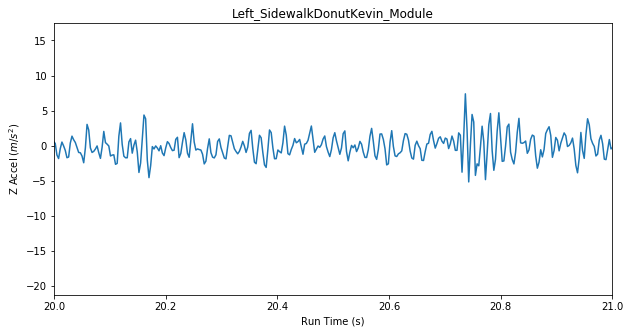

In [9]:
# Plot some raw data
plot_one(raw_datasets, dataset_labels[0], 'Run Time', 'Z Accel', xlim=(20, 21))

In [10]:
# Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(raw_datasets, label, 'Run Time', 'Z Accel', save_fig=True)

In [11]:
'''Compare two Pandas DataFrames by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, dirn, t_offset=0, y_offset=0):
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    
    # Plot data with given y and t offsetson first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][dirn].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][dirn], label=label2)
    
    ax.set_xlabel('Epoch Time ($s$)')
    if 'Gyro' in dirn:
        ax.set_ylabel(dirn + ' ($rad/s$)')
    elif 'Accel' in dirn:
        ax.set_ylabel(dirn + ' ($m/s^2$)')
    
    ax.set_title(dirn + ' for ' + label1 + ' and ' + label2)
    
    # Plot offset info
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

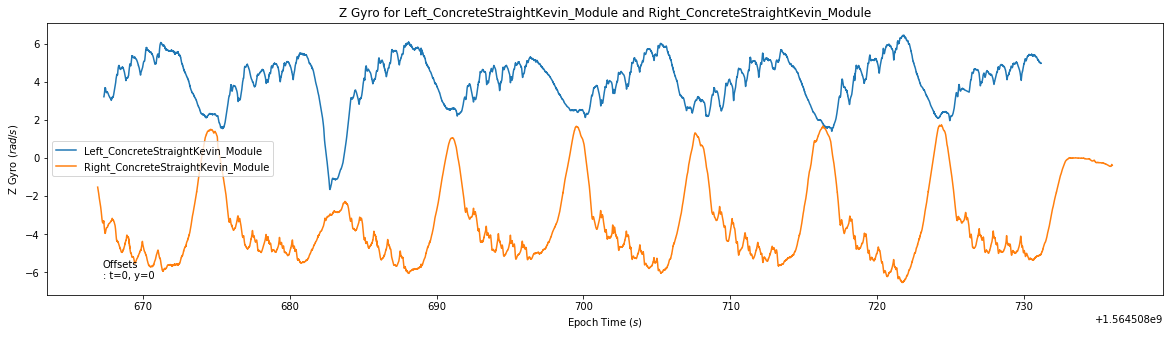

In [12]:
# Compare Z Gyro data for each wheel in the same dataset
dataset_compare(raw_datasets, 'Left_ConcreteStraightKevin_Module',
                raw_datasets, 'Right_ConcreteStraightKevin_Module', 
                dirn='Z Gyro')

In [13]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 1
    
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' (s)')
        
        if 'Gyro' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($rad/s$)')
        elif 'Accel' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($m/s^2$)')
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

<Figure size 432x288 with 0 Axes>

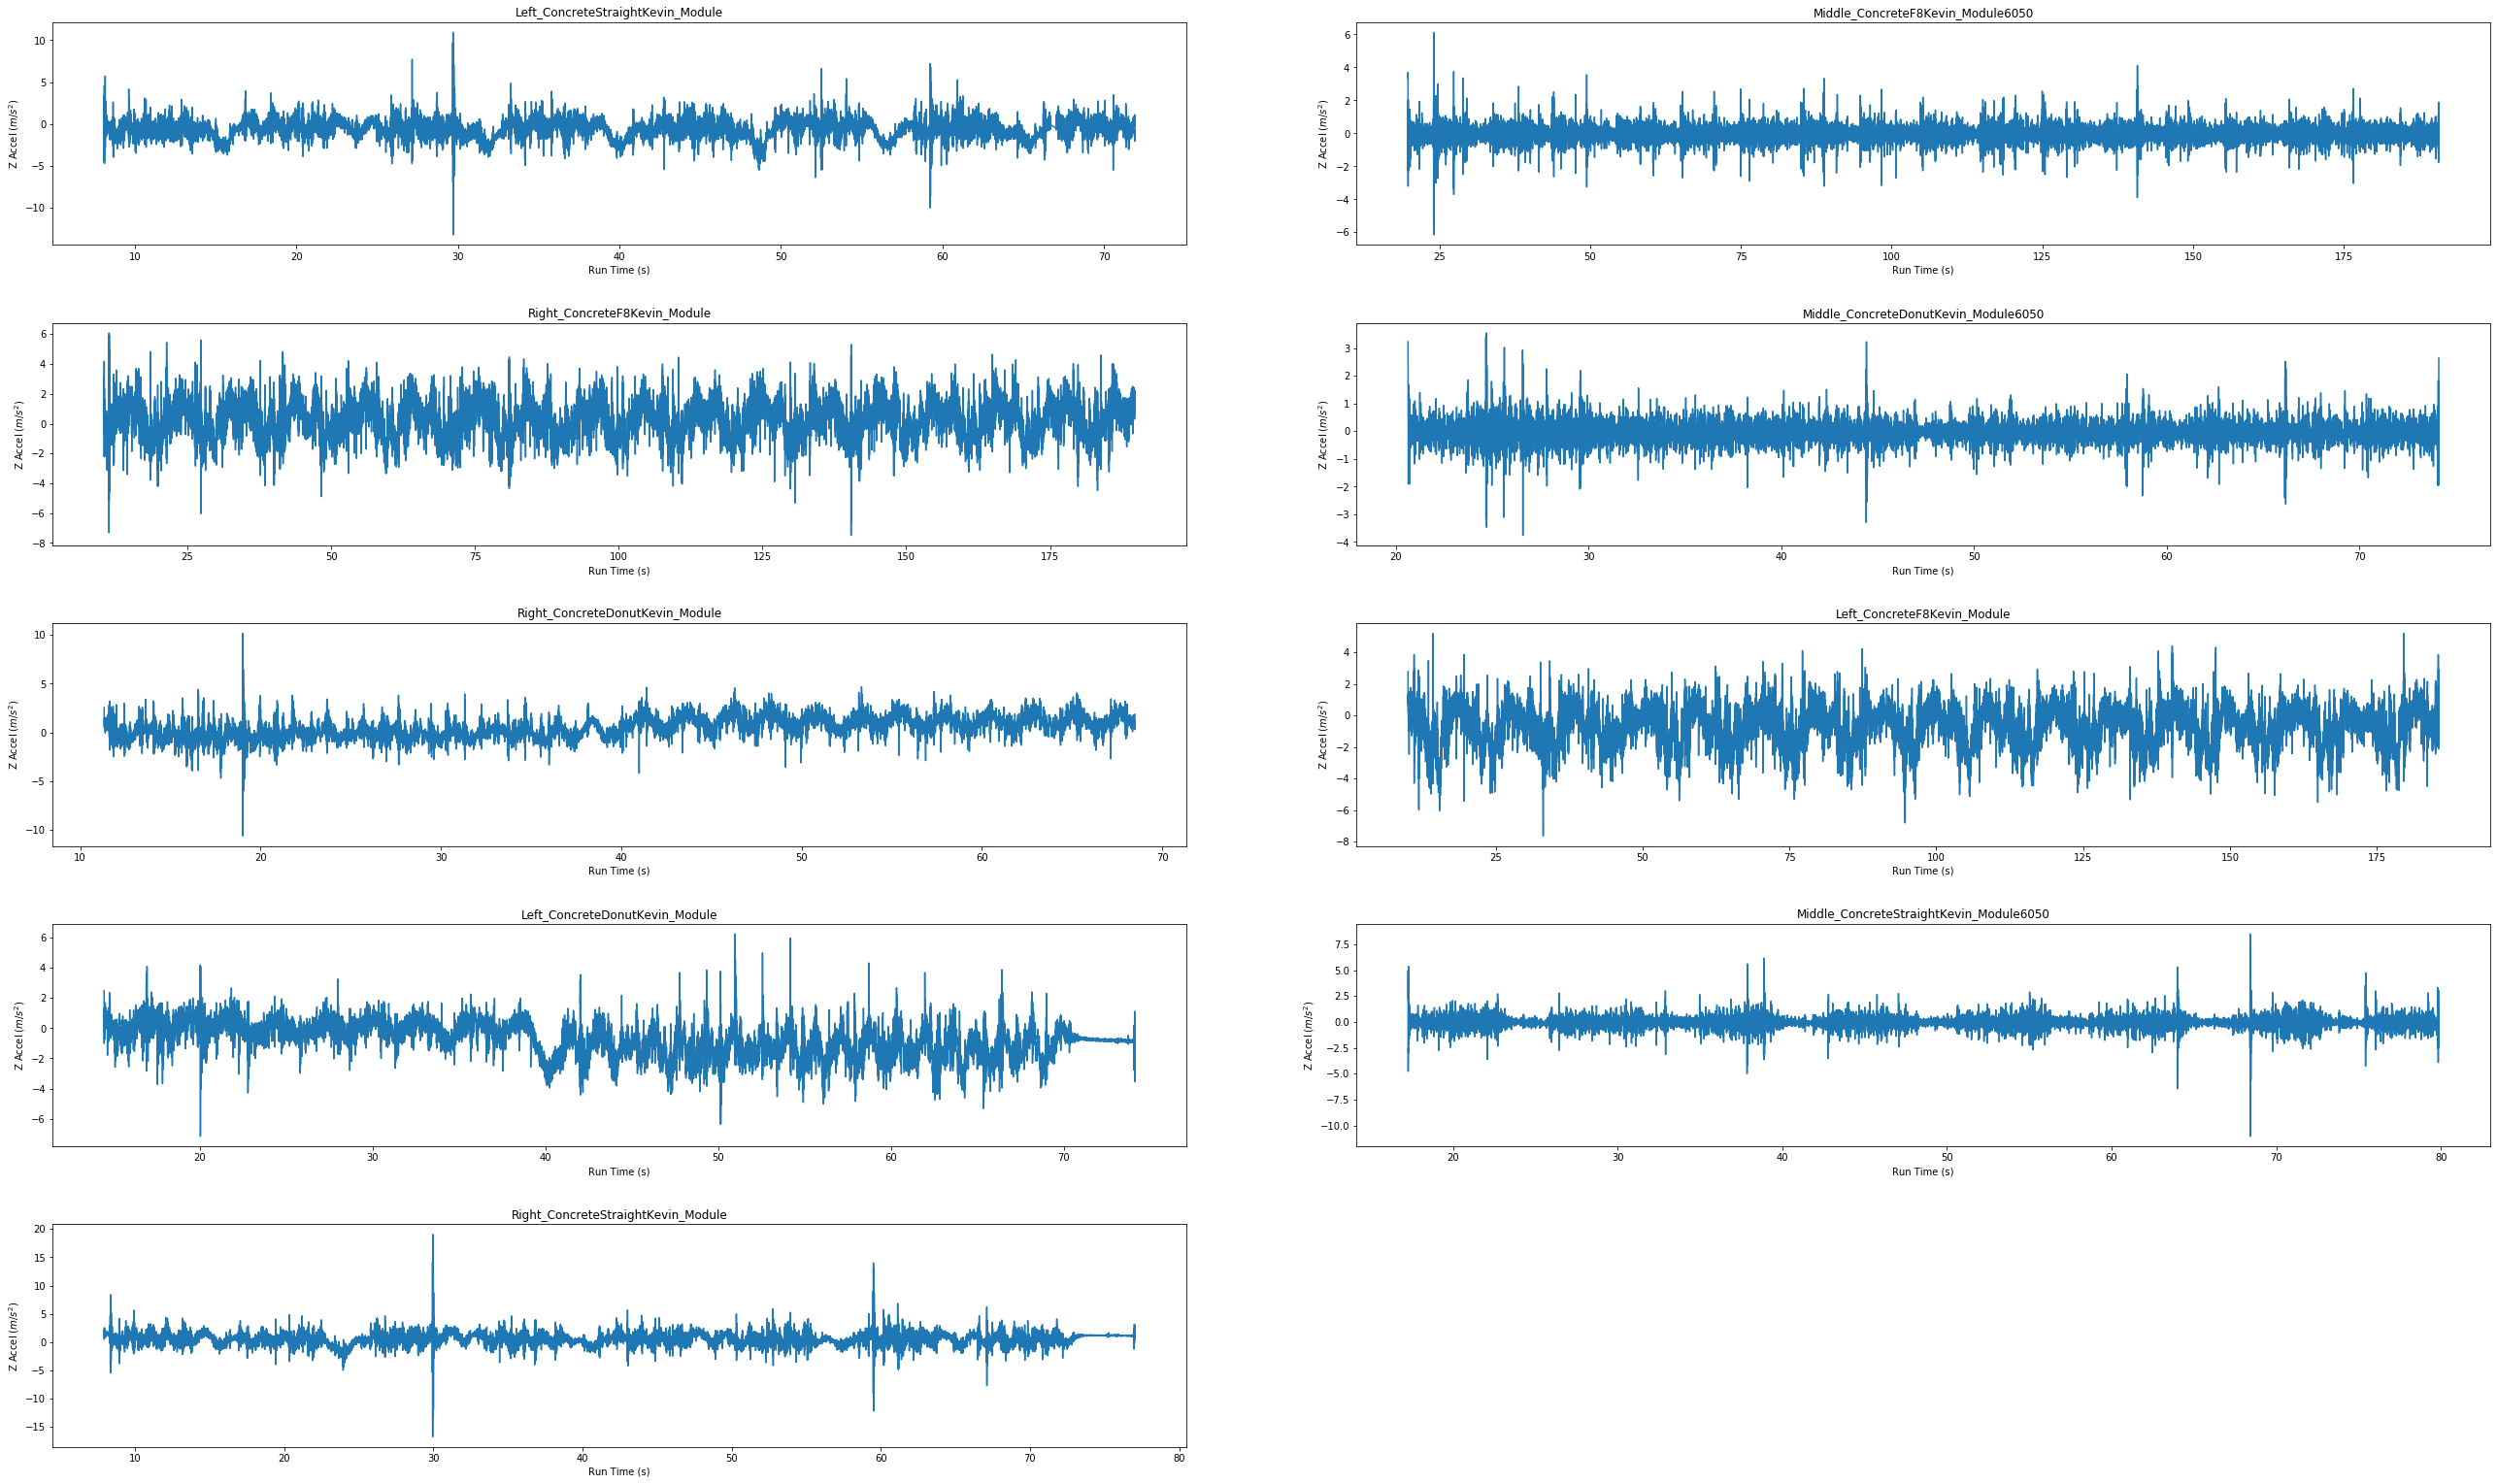

In [14]:
# Plot Z Accel of same dataset for different modules
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Concrete' in label}
plot_all(datasets_to_plot, x_axis='Run Time', y_axis='Z Accel')

### Part (c) - Converting Between Pandas and Numpy

In [15]:
'''Convert array of Pandas DataFrames to array of 2D Numpy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            print('Note: Already a NumPy array!')
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.to_numpy()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [16]:
'''Convert array of 2D Numpy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            print('Note: Already a Pandas dataframe!')
            return np_datasets
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))
                
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [17]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [18]:
# Run to convert back to Pandas
#raw_datasets = np_to_pd(raw_datasets)

In [19]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 63
Shape of first dataset: (29228, 8)


#### Data Structure:

`Terrain Dataset Dictionary 
-> NP Array
---> Row = Datapoint, 
---> Col = Direction | Time`

## Part 2 - Filtering

**Nominally set to 30 % of Nyquist Freq**

In [20]:
'''Get relevant frequencies for given label based on whether its a frame or wheel dataset'''
def get_frequencies(label):
    # Sampling frequency (and thus cutoff frequency) varies between frame and wheel modules
    if 'Left' in label or 'Right' in label:
        f_samp = 333.3 # Sampling frequency
        f_low = 60 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    elif 'Middle' in label:
        f_samp = 300 # Sampling frequency
        f_low = 55 # Low pass cutoff frequency
        f_high = 1 # High pass cutoaff frequency
    else:
        raise Exception('Unknown label format')
        
    return f_samp, f_low, f_high

In [21]:
'''Get window size based on whether label is for a frame or wheel dataset'''
def get_window_size(label):
    if 'Left' in label or 'Right' in label:
        window_size = 333
    elif 'Middle' in label:
        window_size = 300
    else:
        raise Exception('Unknown label format')
    return window_size

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

In [22]:
# Filtered datasets dictionary
datasets = {}

for label, raw_dataset in raw_datasets.items():
    
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    for i in range(N_DATA_COL):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, raw_dataset[:, i])
        
    datasets.update({label: dataset})

<Figure size 432x288 with 0 Axes>

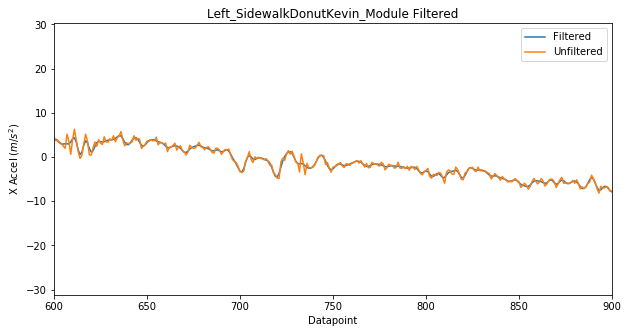

In [23]:
# Compare filtered and unfiltered
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(datasets[dataset_labels[0]][:, 0], label='Filtered')
plt.plot(raw_datasets[dataset_labels[0]][:, 0], label='Unfiltered')
plt.xlim(600, 900)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel('X Accel ($m/s^2$)')
plt.title(dataset_labels[0] + ' Filtered')
plt.show()

In [24]:
## Check construction
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 63
Shape of first filtered dataset: (29228, 8)


In [25]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

X Accel   Y Accel   Z Accel    X Gyro    Y Gyro    Z Gyro  Run Time  \
0 -9.816540  3.003877  2.310034 -0.661420  0.010671  1.737313     7.937   
1 -9.754176  2.411959  1.564431 -0.664723  0.012842  1.742507     7.940   
2 -9.605323  2.060542  0.542918 -0.646542  0.022702  1.748721     7.943   
3 -9.394765  1.929061 -0.447028 -0.611165  0.041083  1.755302     7.946   
4 -9.225753  1.875699 -0.758954 -0.582529  0.060537  1.759997     7.949   

     Epoch Time  
0  1.564597e+09  
1  1.564597e+09  
2  1.564597e+09  
3  1.564597e+09  
4  1.564597e+09

<Figure size 432x288 with 0 Axes>

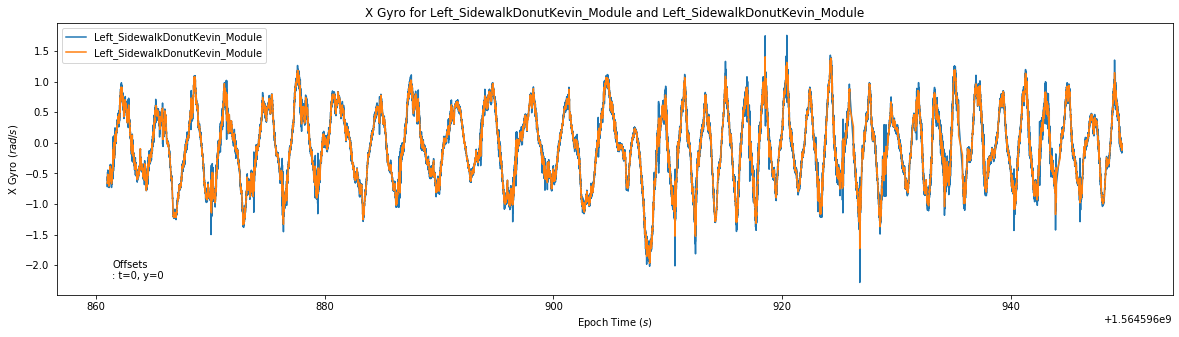

In [26]:
# Again compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[0], 
                np_to_pd(datasets), dataset_labels[0], 'X Gyro')

### Part (b) - Further Time Domain Visualization

In [27]:
'''Compare Z Gyro of frame to calculated value off of two wheels'''
def gyro_compare(dataset, label, xlim=None):
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate Z Gyro off of wheels
    r_wheel = 0.30
    d_base = 0.54
    calc = (r_wheel / d_base)*(-1 * dataset['Left_' + label]['Z Gyro'] - dataset['Right_' + label]['Z Gyro'])
    calc = np.reshape(calc, dataset['Right_' + label]['Epoch Time'].shape)
    
    # Plot actual frame gyro, calculated frame gyro, and actual wheel gyro
    ax.plot(dataset['Middle_' + label]['Epoch Time'], dataset['Middle_' + label]['Z Gyro'], 
            label='Actual Frame')
    ax.plot(dataset['Right_' + label]['Epoch Time'], calc, label='Calculated Frame')
    ax.plot(dataset['Left_' + label]['Epoch Time'], dataset['Left_' + label]['Z Gyro'], 
            label='Actual L Wheel')
    ax.plot(dataset['Right_' + label]['Epoch Time'], dataset['Right_' + label]['Z Gyro'],
            label='Actual R Wheel')
    
    # Other figure stuff
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel('Z Gyro ($m/s^2$)')
    ax.set_title('Comparing Actual to Calculated Z Gyro Data')
    
    if xlim:
        start_time = dataset['Middle_' + label]['Epoch Time'][0]
        ax.set_xlim(xlim[0] + start_time, xlim[1] + start_time)
    ax.legend()
    plt.show()

In [28]:
#gyro_compare(np_to_pd(datasets), 'ConcreteDonutKevin_Module', xlim=(20, 40))

## Part 3 - Time Windows

### Part (a) - Creating Time Windowed Data

In [29]:
datasets_windowed = {}

# Trim excess datapoints, then split into windows
for label, dataset in datasets.items():
    window_size = get_window_size(label)
    n_windows = int(len(dataset) / window_size) # Note: Integer floor
    n_points = n_windows * window_size
    
    dataset_windowed = np.resize(dataset, (n_points, dataset.shape[1]))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_windowed.update({label: dataset_windowed})

In [30]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 63
Num of windows in first dataset: 87
Shape of individual window: (333, 8)


In [31]:
# Try out pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

X Accel   Y Accel   Z Accel    X Gyro    Y Gyro    Z Gyro  Run Time  \
328  4.695305  7.490699  0.201134  0.378837  0.501831  2.327312     8.921   
329  4.984660  7.292600 -0.280242  0.373524  0.516507  2.343527     8.924   
330  5.511709  7.365765 -0.159094  0.378864  0.496802  2.349516     8.927   
331  5.899925  7.679914  0.786646  0.383008  0.461911  2.349231     8.930   
332  6.009980  8.079441  2.038005  0.376252  0.439154  2.352199     8.933   

       Epoch Time  
328  1.564597e+09  
329  1.564597e+09  
330  1.564597e+09  
331  1.564597e+09  
332  1.564597e+09

<Figure size 432x288 with 0 Axes>

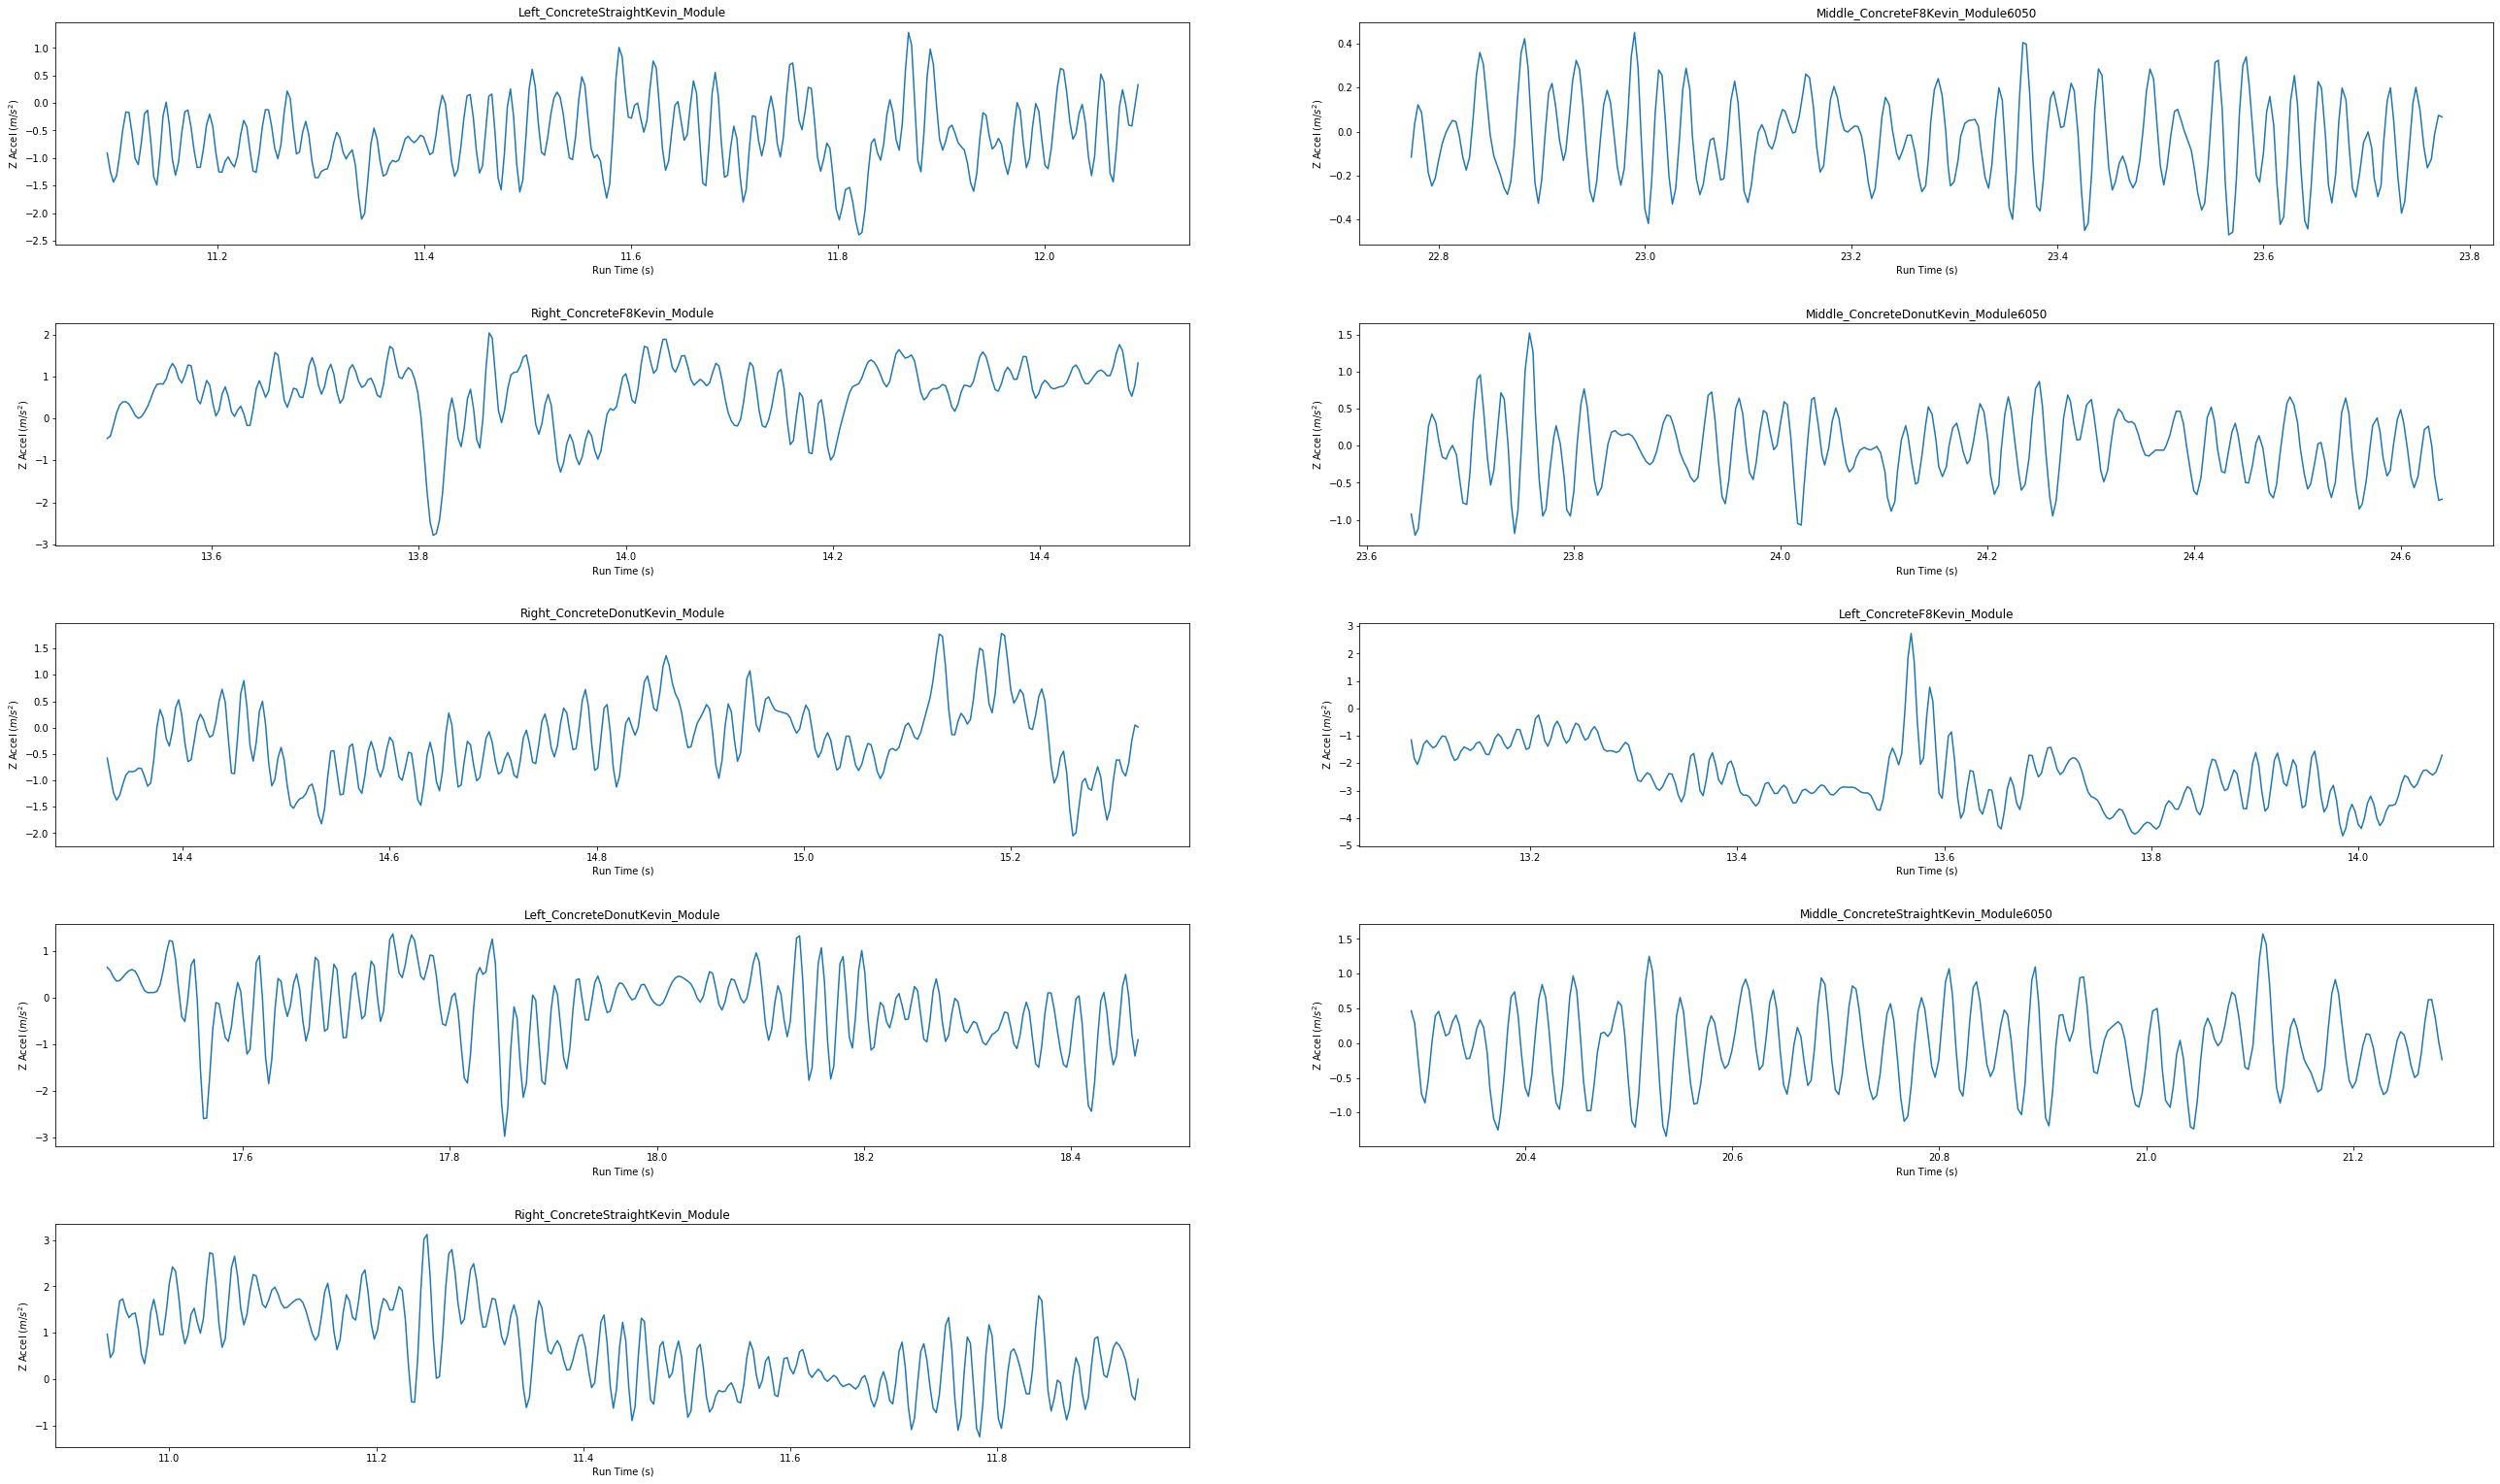

In [32]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if 'Concrete' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='Z Accel', windowed=True, win_num=3)

#### Data Structure

`Terrain Dataset Dictionary
-> Data Window List
---> NP Array
-----> Row = Datapoint
-----> Col = Direction | Time`

## Part 4 - Transforms

In [33]:
'''Plot tranform of given direction and window of a windowed dataset dictionary'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + data_columns[dirn] + ', Window {}')
    plt.show()

### Part (a) - FFT

In [34]:
datasets_fft = {}
N_BINS_OVER_CUTOFF = 5 # Number of frequency bins past the cutoff frequency to include

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Sampling frequency dependent on device
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_fft = np.zeros((n_bins, N_DATA_COL))
        
        for i in range(N_DATA_COL):
            # FFT is normalized to window size, to ensure consistency between different size choices
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), window_size)), n_bins)
            
        # Get positive frequency bins for given FFT parameters
        freq_col = np.transpose([np.resize(np.fft.fftfreq(window_size, 1 / f_samp), n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + 'FFT': dataset_fft})

In [35]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'FFT'][0].shape))

# Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'FFT'][0].head()

Num of FFT'd windowed datasets: 63
Num of FFT'd windows in first dataset: 173
Shape of FFT'd individual window: (64, 7)


X Accel   Y Accel   Z Accel    X Gyro    Y Gyro    Z Gyro  Frequency
0  2.444590  7.764405  0.357790  0.222211  0.475163  2.141687   0.000000
1  2.980557  1.426882  0.152352  0.222855  0.115386  0.062039   1.000901
2  1.346062  0.571994  0.090937  0.065310  0.081107  0.035233   2.001802
3  0.798775  0.285386  0.051494  0.082747  0.022758  0.050235   3.002703
4  0.514012  0.152475  0.109502  0.034238  0.034668  0.019720   4.003604

<Figure size 432x288 with 0 Axes>

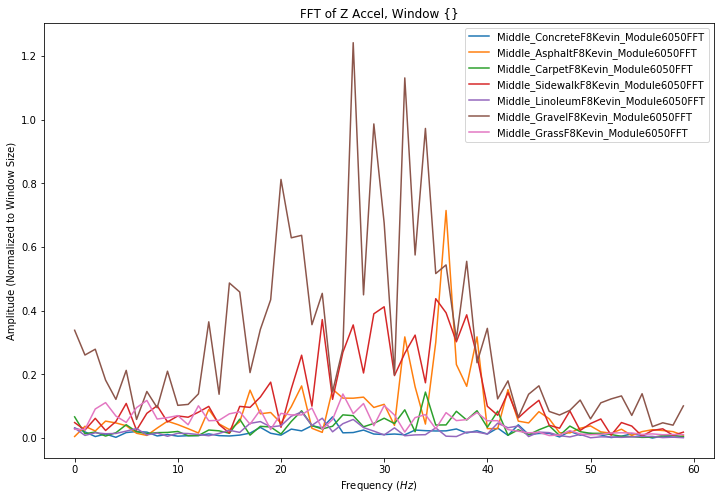

In [36]:
# Plot Middle Z Accel of 10th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(ffts_to_plot, win_num=10, dirn=2, transform_name='FFT')

<Figure size 432x288 with 0 Axes>

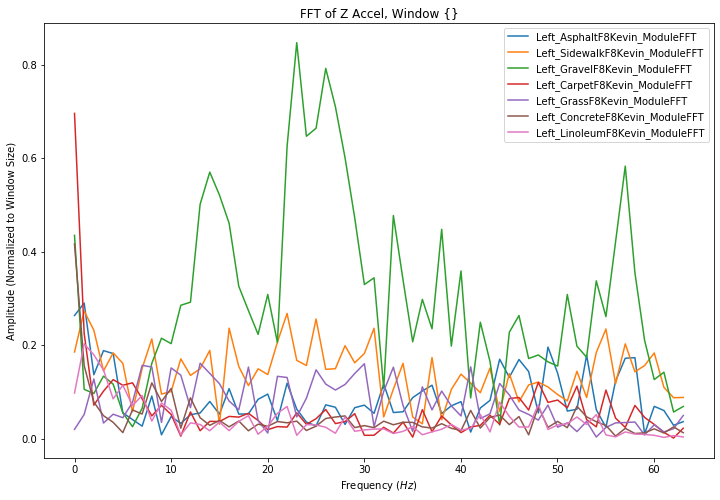

In [37]:
# Plot Left Z Accel of 10th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Left' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(ffts_to_plot, win_num=10, dirn=2, transform_name='FFT')

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

<Figure size 432x288 with 0 Axes>

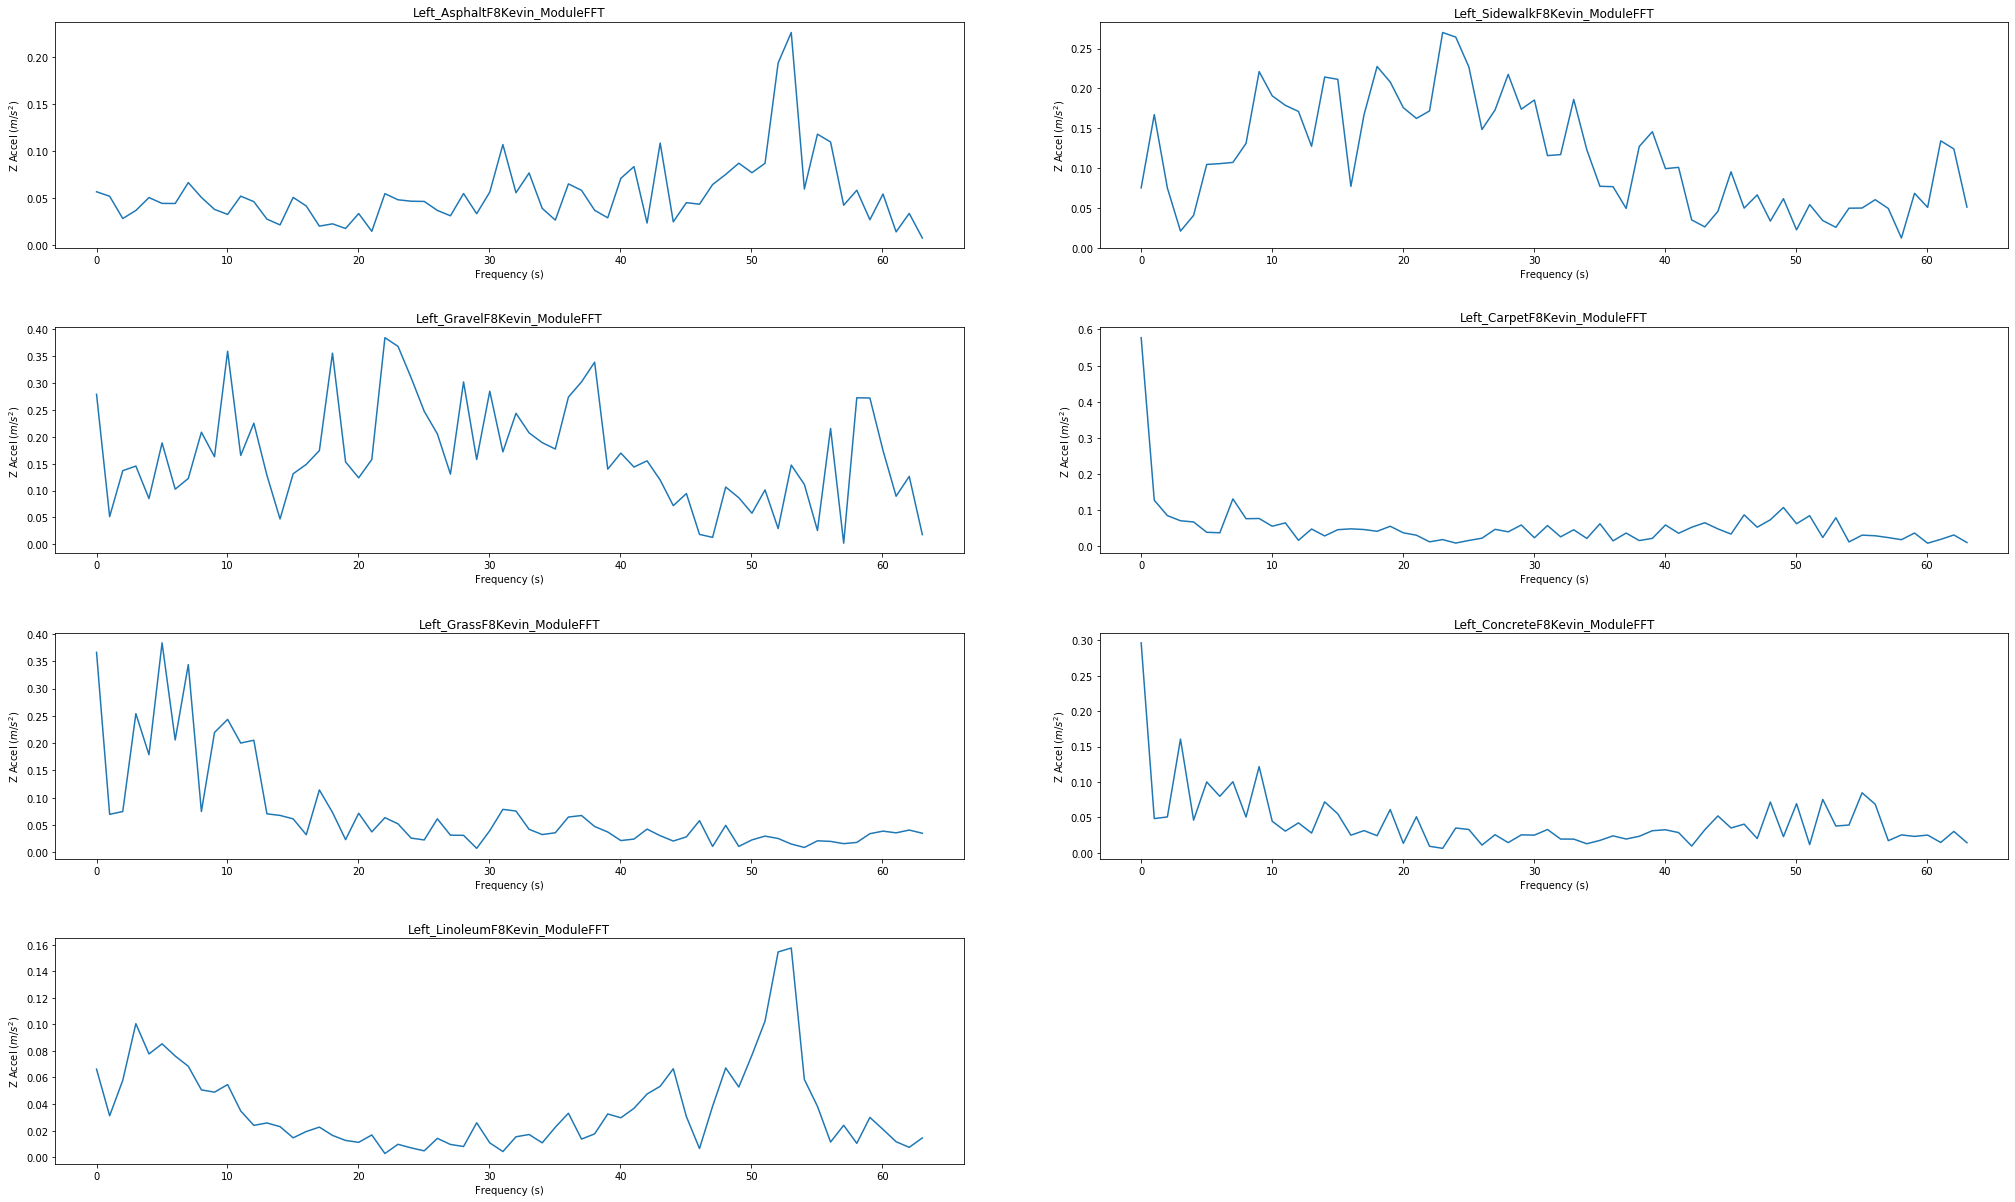

In [38]:
# Plot all the Frame FFTs for 0th window
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='Z Accel', windowed=True)

### Part (b) - PSD

In [39]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Frequencies depedent on dataset and device used
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_psd = np.zeros((n_bins, N_DATA_COL))
        window_psd_log = np.zeros((n_bins, N_DATA_COL))
        
        # Calculate PSD for each axes
        for i in range(N_DATA_COL):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            
            # Calculate log10 of PSD, replacing points where PSD = 0 with 0 to avoid division by 0
            for j in range(len(window_psd[:, i])):
                if (window_psd[j, i] == 0):
                    window_psd_log[j, i] = 0
                else:
                    window_psd_log[j, i] = np.log10(window_psd[j, i])
            
        # Append freq column
        freq_col = np.transpose([np.resize(freq[:-1], n_bins)])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + 'PSD': dataset_psd})
    datasets_psd_log.update({label +'PSDLog': dataset_psd_log})

In [40]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'PSD'][0].shape))

Num PSD'd windowed datasets: 63
Num of PSD'd windows in first dataset: 87
Shape of PSD'd individual window: (64, 7)


<Figure size 432x288 with 0 Axes>

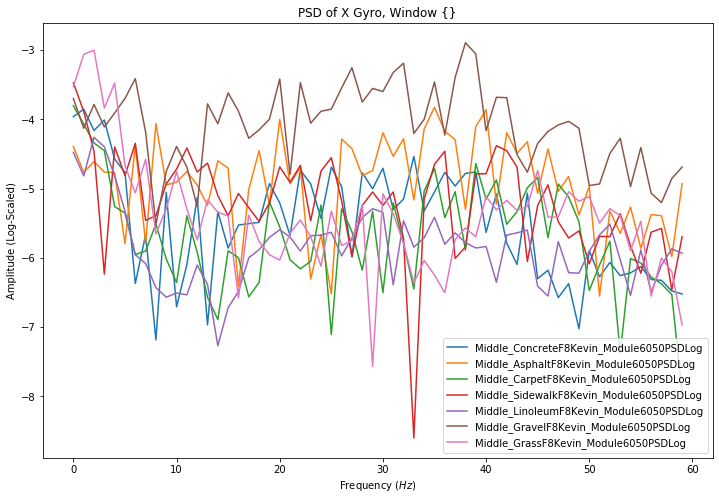

In [41]:
# Plot Z Accel of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=3, transform_name='PSD')

<Figure size 432x288 with 0 Axes>

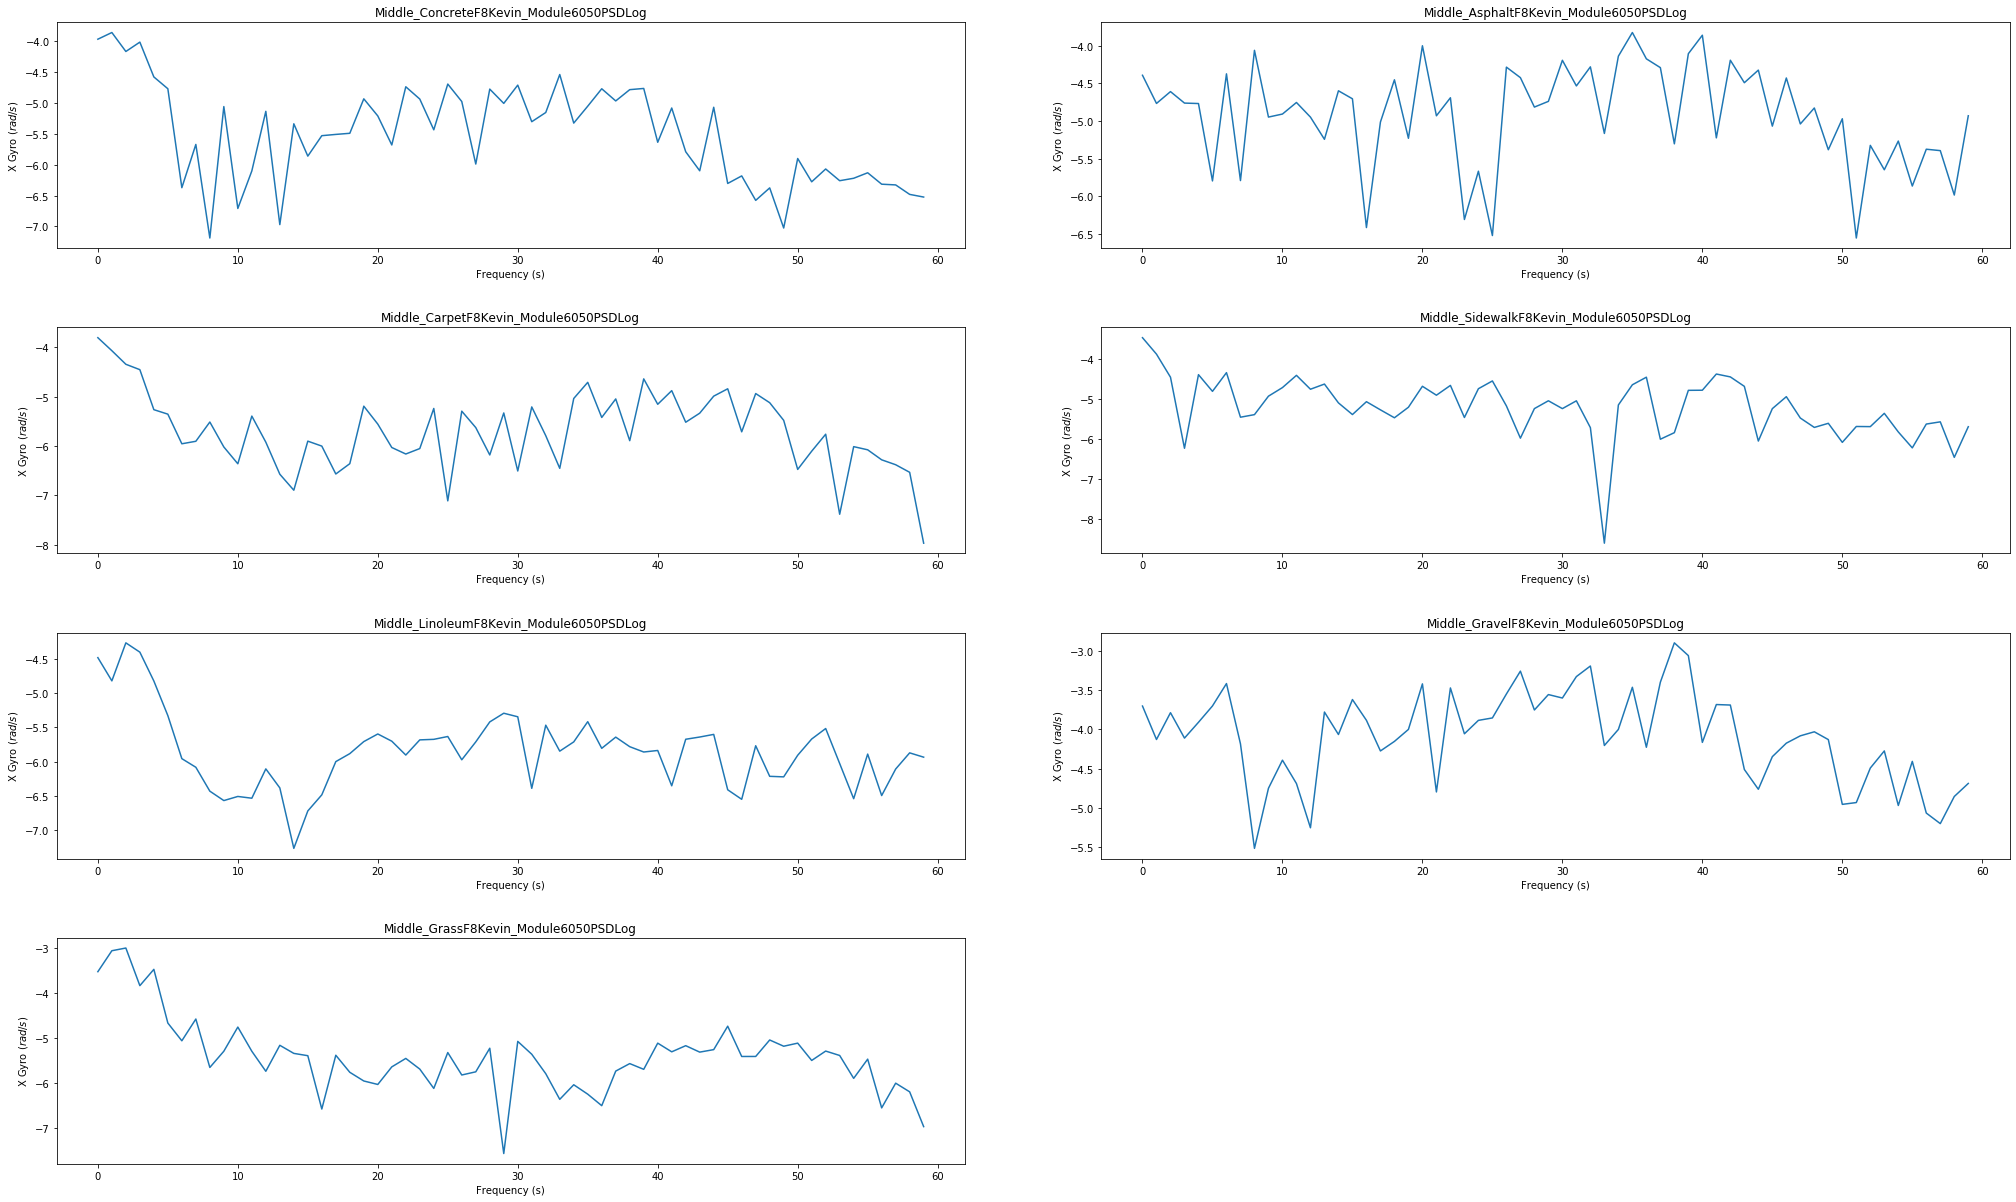

In [42]:
# Plot all PSDs of Z Accel for 0th window
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='X Gyro', windowed=True)

#### Data Structure:

`Labelled Terrain Dataset
-> Time Window
---> 2D NumPy Array
-----> Row = Transform Value for Frequency
-----> Col = Dirn | Frequency`

### Part (c) - 3D Visualization

In [43]:
'''Plot the set transforms in 3d'''
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific to FFT or PSD
    if transform_name == 'FFT':
        z_lim = (0, 1.6)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Normalized to Window Size)')
        
    elif transform_name == 'PSD':
        z_lim = (-10, -30)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    n_datasets = len(datasets_transformed)
    
    # Change y axis to corespond with terrain labels
    ax.set_ylim(0.5, n_datasets+0.5)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1.5))
    y_labels = [get_terrain_name(get_terrain_num(key)) for key in datasets_transformed.keys()]
    ax.set_yticklabels(y_labels)
    
    
    ax.set_xlabel('Frequency ($Hz$)')
    ax.set_title(transform_name + ' of ' + data_columns[dirn] + ', Window {}')
    
    # Bar graph paremeters
    width = depth = 0.75
    
    # TODO: Sort by max amplitude
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        # To plot
        x = dataset[win_num][:, -1]
        y = [i+1]
        top = dataset[win_num][:, dirn]
        
        # Specific to transform
        bot = np.full(top.shape, z_lim[0])
        ax.bar3d(x, y, bot, width, depth, top, alpha=0.8)
    
    plt.show()

<Figure size 432x288 with 0 Axes>

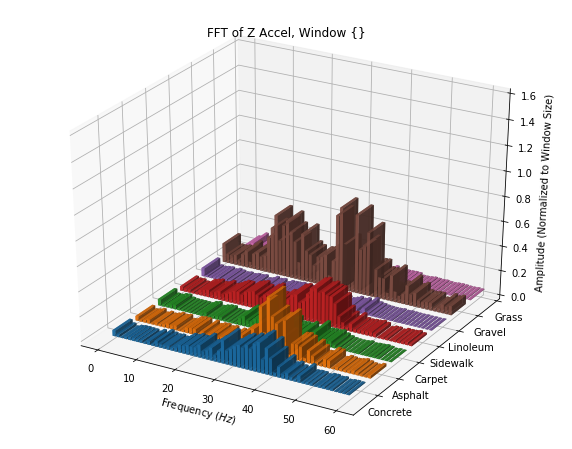

In [44]:
# Plot 3D Z Accel FFT of 0th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_transforms_3d(ffts_to_plot, win_num=4, dirn=2, transform_name='FFT')

<Figure size 432x288 with 0 Axes>

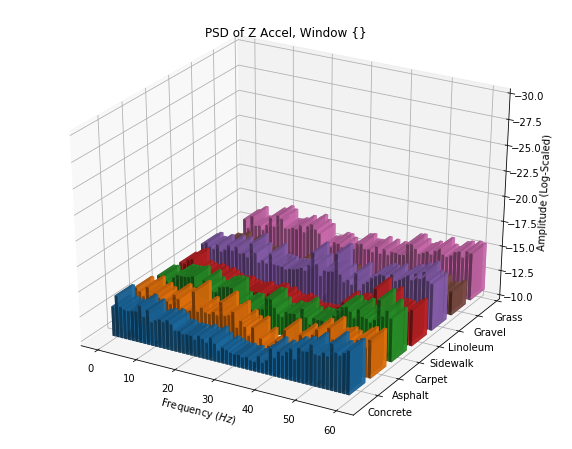

In [45]:
# Plot 3D Z Accel PSD of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label }
plot_transforms_3d(psds_to_plot, win_num=4, dirn=2, transform_name='PSD')

### Part (d) - Spectograms

In [46]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size):
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(data_columns[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

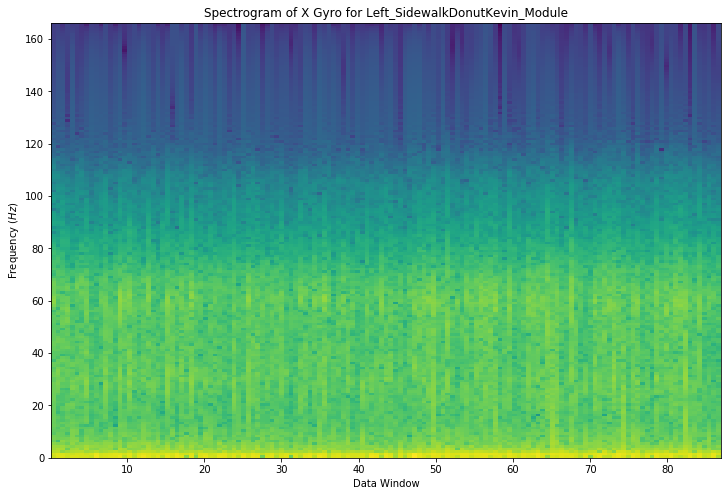

In [47]:
# X Accel
plot_spectogram(dataset_labels[0], dirn=3, size=get_window_size(dataset_labels[0]))

## Part 5 - Feature Extraction

#### Extract possibly relevant features (e.g. Mean, Min, Skew) from each data window

In [48]:
# Feature extraction functions

# For small float values
EPSILON = 0.00001

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    # divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [49]:
'''Extract given features from everything in dataset'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:N_DATA_COL]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window
                    
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('PSD', ''): directions})
    
    return datasets_feat

In [50]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name, placement_name, ylim=None, xlim=None):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
        
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(placement_name + ' ' + dirn)
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [51]:
# Time domain feature functions and names
time_features = {'Mean': np.mean, 'Std Dev': np.std,  'L2 Norm': l2norm, 'Autocorrelation': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'Root Mean Squared': rms, 'Zero Crossing Rate': zcr, 
                 'Skew': stats.skew, 'Excess Kurtosis': stats.kurtosis} 

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [52]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['X Gyro'].shape))

Num datasets: 63
Num directions: 6
Shape of first dataset first direction: (87, 10)


<Figure size 432x288 with 0 Axes>

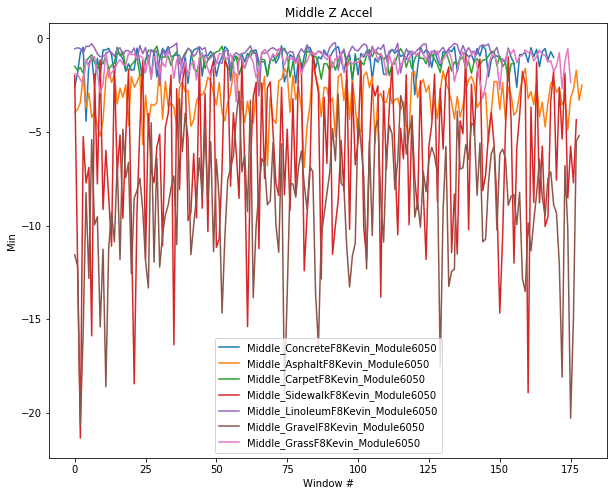

In [53]:
# Plot Min of frame Z Accel
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Middle' in label in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Z Accel', feat_name='Min', placement_name='Middle')

### Part (b) - Frequency Domain Features

In [54]:
# Frequency domain feature functions and names
freq_features = {'Mean Square Frequency': msf, 'Root Mean Square Frequency': rmsf, 'Frequency Center': fc, 
                 'Variance Frequency': vf, 'Root Variance Frequency': rvf}

# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

In [55]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['X Gyro'].shape))

Num datasets: 63
Num directions: 6
Shape of one direction: (87, 5)


<Figure size 432x288 with 0 Axes>

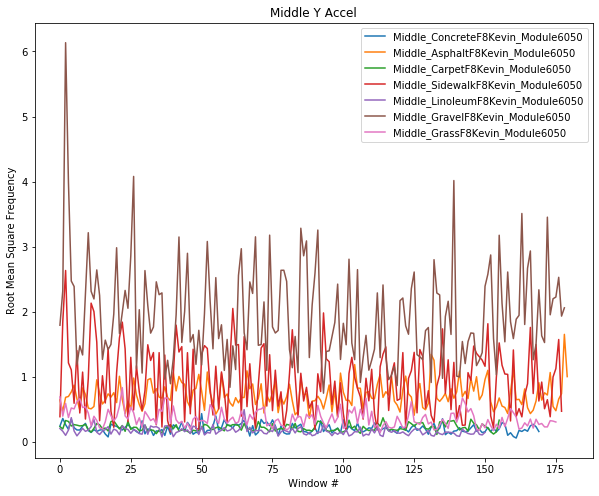

In [56]:
# Plot RMSF of Y Accel
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Y Accel', feat_name='Root Mean Square Frequency', placement_name='Middle')

#### Data Structure

`Terrain Dataset Dictionary
-> Direction Dictionary 
---> Pandas Array
-----> Row = Window #
-----> Col = Extracted Feature`

## Part 6 - Standardization, Columning, and Combining Datasets

**Since Z Gyro data is often cutoff out of range on old datasets, possible to get PSD of zero which results in NaN values**

This is likely the cause of some of the errors below

In [57]:
# Convert transformed data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

In [58]:
# Run to convert transformed data back to Numpy
#datasets_fft = pd_to_np(datasets_fft, windowed=True)
#datasets_psd_log = pd_to_np(datasets_psd_log, windowed=True)

In [59]:
# Add time and frequency features together
datasets_feat = {}

for label, dataset in datasets_feat_time.items():
    dataset_feat = {}
    
    for dirn_label, dirn_df in dataset.items():
        new_df = dirn_df.join(datasets_feat_freq[label][dirn_label], how='outer')
        dataset_feat.update({dirn_label: new_df})
    
    datasets_feat.update({label: dataset_feat})

In [60]:
# Confirm formatting
datasets_feat[dataset_labels[0]]['Y Accel'].head()

Mean   Std Dev     L2 Norm  Autocorrelation        Max        Min  \
0  7.764405  2.499863  148.849766     22156.252732  13.762680   1.875699   
1 -2.479285  5.495051  110.009242     12102.033366   8.959132 -13.429050   
2 -7.768925  2.317435  147.942536     21886.993969  -2.259556 -12.818291   
3  5.653354  4.436949  131.142776     17198.427742  11.227438  -3.655076   
4  3.956289  4.910536  115.073637     13241.942024  10.821151  -9.230038   

   Root Mean Squared  Zero Crossing Rate      Skew  Excess Kurtosis  \
0           8.156917            0.000000 -0.617333        -0.412197   
1           6.028469            0.009009  0.241166        -1.042213   
2           8.107201            0.000000  0.627686        -0.486471   
3           7.186580            0.003003 -0.762237        -0.882680   
4           6.305996            0.015015 -0.691313        -0.351529   

   Mean Square Frequency  Root Mean Square Frequency  Frequency Center  \
0               0.311034                    0.557704          5.584183   
1               1.146808                    1.070891          2.776408   
2               0.357638                    0.598028          5.819395   
3               0.818171                    0.904528          1.927010   
4               1.486762                    1.219328          3.352429   

   Variance Frequency  Root Variance Frequency  
0          -30.872071                 0.557704  
1           -6.561635                 1.070891  
2          -33.507715                 0.598028  
3           -2.895194                 0.904528  
4           -9.752018                 1.219328

### Part (a) - Standardization

#### Standardize each feature to mean 0 and standard deviation 1. This makes feature selection and classification easier.

In [61]:
'''Normalize already featured datasets'''
def normalize_datasets(datasets, windowed=False):
    # Normalization function
    from sklearn.preprocessing import scale
    
    datasets_norm = {}
    
    # Go through windowed data (transforms) or dictionary data (features)
    for label, dataset in datasets.items():
        if windowed:
            dataset_norm = []
            for window_df in dataset:
                window_df = window_df.dropna()
                dataset_norm.append(window_df.apply(scale))
        else:
            dataset_norm = {}
            for dirn_label, dirn_df in dataset.items():
                dirn_df = dirn_df.dropna()
                dataset_norm.update({dirn_label: dirn_df.apply(sklearn.preprocessing.scale)})
        
        datasets_norm.update({label: dataset_norm})
    
    return datasets_norm

In [62]:
# So we can remove infinites
pd.set_option('use_inf_as_na', True)

datasets_feat_norm = normalize_datasets(datasets_feat)
datasets_fft_norm = normalize_datasets(datasets_fft, windowed=True)
datasets_psd_norm = normalize_datasets(datasets_psd_log, windowed=True)

In [63]:
datasets_feat_norm[dataset_labels[0]]['Y Accel'].head()

Mean   Std Dev   L2 Norm  Autocorrelation       Max       Min  \
0  1.564426 -1.210508  1.090710         1.113812  0.752620  2.141388   
1 -0.543651  0.335659 -1.027063        -1.032058 -0.062663 -0.908084   
2 -1.632221 -1.304680  1.041244         1.056344 -1.966757 -0.786390   
3  1.129987 -0.210551  0.125240         0.055665  0.322326  1.039380   
4  0.780743  0.033923 -0.750927        -0.788767  0.253369 -0.071431   

   Root Mean Squared  Zero Crossing Rate      Skew  Excess Kurtosis  \
0           1.090710           -0.977105 -1.099719         0.525221   
1          -1.027063           -0.151783  0.433863        -0.310734   
2           1.041244           -0.977105  1.124324         0.426669   
3           0.125240           -0.701998 -1.358569        -0.099052   
4          -0.750927            0.398431 -1.231874         0.605719   

   Mean Square Frequency  Root Mean Square Frequency  Frequency Center  \
0              -0.851774                   -0.935754          0.697113   
1               0.346764                    0.532473         -0.204237   
2              -0.784941                   -0.820386          0.772621   
3              -0.124516                    0.056510         -0.476911   
4               0.834273                    0.957152         -0.019323   

   Variance Frequency  Root Variance Frequency  
0           -0.144317                -0.935754  
1            0.192144                 0.532473  
2           -0.180794                -0.820386  
3            0.242888                 0.056510  
4            0.147988                 0.957152

<Figure size 432x288 with 0 Axes>

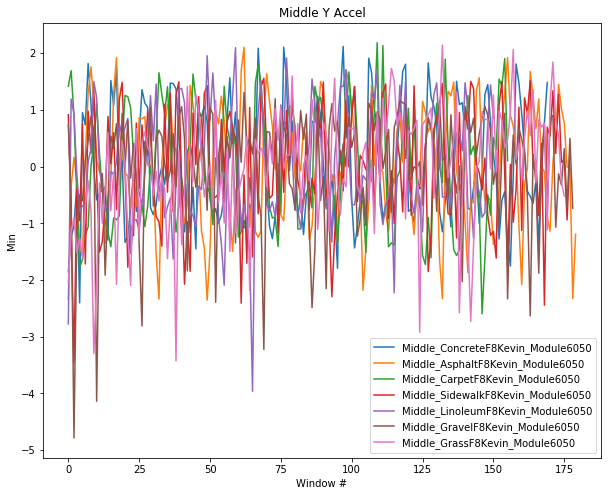

In [64]:
# Plot normalized features
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_norm.items() if 'Middle' in label in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Y Accel', feat_name='Min', placement_name='Middle')

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

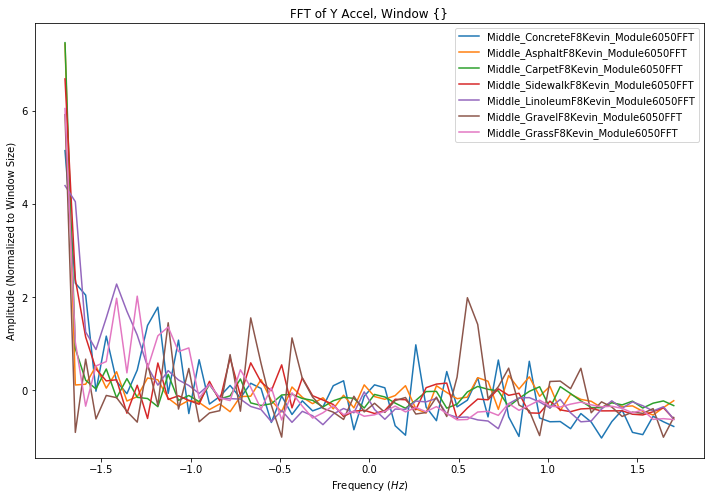

In [65]:
# Plot normalized fft
ffts_to_plot = {label: dataset for label, dataset in datasets_fft_norm.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(pd_to_np(ffts_to_plot, windowed=True), dirn=1, win_num=0, transform_name='FFT')

### Part (b) - Columning Data

#### Combine IMU data from each direction into single dataframes with columns for each feature in each direction

#### Part (i) - Extracted Featured Data

In [66]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

In [67]:
'''Combined directions of a featured dataset'''
def combine_columns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [68]:
# Take frame data and combine directions
datasets_feat_columned = combine_columns(datasets_feat_norm)

# Confirm formatting
datasets_feat_columned[dataset_labels[0]].head()

Mean X Accel Left  Std Dev X Accel Left  L2 Norm X Accel Left  \
0          -0.451595              0.788350             -1.055678   
1           1.337406             -1.037263              0.841101   
2          -0.802594             -0.355057             -1.144749   
3          -1.085047             -0.420304             -0.024704   
4           1.309091             -0.819085              0.806285   

   Autocorrelation X Accel Left  Max X Accel Left  Min X Accel Left  \
0                     -1.123242         -0.388404         -0.417771   
1                      0.877531          0.426180          1.517661   
2                     -1.201911         -0.950119         -0.420777   
3                     -0.112879         -1.237335         -0.626774   
4                      0.835205          0.810195          1.403655   

   Root Mean Squared X Accel Left  Zero Crossing Rate X Accel Left  \
0                       -1.055678                         1.329912   
1                        0.841101                        -1.052195   
2                       -1.144749                         1.329912   
3                       -0.024704                         0.649310   
4                        0.806285                        -0.371593   

   Skew X Accel Left  Excess Kurtosis X Accel Left  ...  Min Z Gyro Left  \
0           0.189010                     -1.268577  ...        -0.446418   
1          -1.322113                      0.160277  ...        -0.586204   
2           0.253796                     -0.646489  ...        -1.164709   
3           0.521688                     -0.960606  ...        -0.589627   
4          -0.879480                      0.021496  ...        -0.467249   

   Root Mean Squared Z Gyro Left  Zero Crossing Rate Z Gyro Left  \
0                      -0.565455                             0.0   
1                      -0.459691                             0.0   
2                      -1.417707                             0.0   
3                      -0.733042                             0.0   
4                      -0.373130                             0.0   

   Skew Z Gyro Left  Excess Kurtosis Z Gyro Left  \
0         -1.659074                     1.964420   
1         -1.482022                     0.826170   
2         -0.426798                    -0.612192   
3          1.036582                    -0.302760   
4          2.098836                     0.632029   

   Mean Square Frequency Z Gyro Left  Root Mean Square Frequency Z Gyro Left  \
0                          -0.177911                                0.064759   
1                           0.766665                                1.021094   
2                          -0.607710                               -0.638445   
3                          -0.664314                               -0.772839   
4                           0.689990                                0.956664   

   Frequency Center Z Gyro Left  Variance Frequency Z Gyro Left  \
0                      2.624110                       -2.865621   
1                      0.491516                       -0.113377   
2                     -0.055049                        0.257491   
3                     -0.642153                        0.506780   
4                     -0.142341                        0.306249   

   Root Variance Frequency Z Gyro Left  
0                             0.064759  
1                             1.021094  
2                            -0.638445  
3                            -0.772839  
4                             0.956664  

[5 rows x 90 columns]

#### Part (ii) - Transformed Data

In [69]:
'''Combined direction columns for transformed data'''
def combine_transform_columns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        combined_windows = []
        
        for window in dataset:
            window_as_row = pd.DataFrame()
            
            # Turn each window 2D dataframe into a single row dataframe
            for row in window.iterrows():
                for data_column in data_columns:
                    combined_column_name = get_transform(label) + ' {} Hz '.format(round(row[1]['Frequency']))
                    combined_column_name +=  data_column + ' ' + get_placement(label)
                    window_as_row.insert(0, combined_column_name, [row[1][data_column]])
            
            combined_windows.append(window_as_row)
        
        # Combine all the single row dataframes into one dataframe
        combined_datasets.update({label: pd.concat(combined_windows, ignore_index=True)})
    
    return combined_datasets

In [70]:
datasets_fft_columned = combine_transform_columns(datasets_fft)

In [71]:
datasets_psd_log_columned = combine_transform_columns(datasets_psd_log)

In [72]:
# Check FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT'].tail()

FFT 63.0 Hz Z Gyro Left  FFT 63.0 Hz Y Gyro Left  FFT 63.0 Hz X Gyro Left  \
82                 0.001702                 0.001696                 0.008611   
83                 0.001376                 0.003263                 0.002129   
84                 0.000490                 0.000736                 0.004176   
85                 0.001364                 0.002606                 0.004251   
86                 0.000600                 0.001870                 0.002021   

    FFT 63.0 Hz Z Accel Left  FFT 63.0 Hz Y Accel Left  \
82                  0.078961                  0.078394   
83                  0.057734                  0.020907   
84                  0.029367                  0.035243   
85                  0.044104                  0.042687   
86                  0.015451                  0.022734   

    FFT 63.0 Hz X Accel Left  FFT 62.0 Hz Z Gyro Left  \
82                  0.066231                 0.001363   
83                  0.047428                 0.001485   
84                  0.043681                 0.000559   
85                  0.058168                 0.000629   
86                  0.046475                 0.001243   

    FFT 62.0 Hz Y Gyro Left  FFT 62.0 Hz X Gyro Left  \
82                 0.001890                 0.002570   
83                 0.000859                 0.004924   
84                 0.000999                 0.002727   
85                 0.003466                 0.004026   
86                 0.003699                 0.003767   

    FFT 62.0 Hz Z Accel Left  ...  FFT 1.0 Hz X Gyro Left  \
82                  0.047923  ...                0.319348   
83                  0.027020  ...                0.309164   
84                  0.011529  ...                0.227991   
85                  0.036140  ...                0.186240   
86                  0.021363  ...                0.223909   

    FFT 1.0 Hz Z Accel Left  FFT 1.0 Hz Y Accel Left  FFT 1.0 Hz X Accel Left  \
82                 0.253356                 3.885924                 4.651084   
83                 0.366766                 1.791806                 3.754082   
84                 0.098184                 2.088112                 3.353808   
85                 0.119564                 2.461042                 3.326623   
86                 0.271700                 2.643101                 2.789614   

    FFT 0.0 Hz Z Gyro Left  FFT 0.0 Hz Y Gyro Left  FFT 0.0 Hz X Gyro Left  \
82                3.026324                0.053224                0.003560   
83                2.869035                0.694167                0.025144   
84                2.766795                0.159880                0.261761   
85                2.882584                0.556683                0.099721   
86                3.030747                0.174076                0.346280   

    FFT 0.0 Hz Z Accel Left  FFT 0.0 Hz Y Accel Left  FFT 0.0 Hz X Accel Left  
82                 1.348245                 2.469204                 0.266552  
83                 0.612127                 7.098722                 0.771575  
84                 1.198202                 6.598002                 1.929651  
85                 0.540867                 5.750836                 4.298471  
86                 1.224448                 4.929569                 4.832500  

[5 rows x 384 columns]

In [73]:
# Check PSD data
datasets_psd_log_columned[dataset_labels[0] + 'PSDLog']

PSD 63.0 Hz Z Gyro Left  PSD 63.0 Hz Y Gyro Left  PSD 63.0 Hz X Gyro Left  \
0                 -5.440289                -6.733936                -4.382898   
1                 -5.376286                -4.440547                -4.881707   
2                 -6.387327                -4.951287                -4.447185   
3                 -6.058776                -5.432337                -5.924180   
4                 -4.915937                -4.697795                -4.570653   
5                 -4.486768                -5.630436                -4.262465   
6                 -4.472537                -4.936073                -4.616852   
7                 -4.920046                -4.538313                -5.703229   
8                 -6.544091                -5.452467                -4.580761   
9                 -5.651770                -5.159530                -3.710352   
10                -5.145648                -4.677580                -4.328748   
11                -4.578544                -5.706660                -4.466919   
12                -5.944371                -5.049787                -4.308289   
13                -5.252618                -5.101144                -6.119012   
14                -8.157143                -5.827429                -4.999841   
15                -5.862280                -4.786571                -4.389647   
16                -6.132827                -4.600563                -4.502335   
17                -5.630250                -4.953693                -5.476789   
18                -5.116999                -4.751245                -5.670943   
19                -5.100050                -4.959090                -4.600889   
20                -6.871863                -5.050254                -6.257409   
21                -5.940692                -7.097372                -4.427187   
22                -5.332597                -4.808979                -4.750406   
23                -6.357791                -5.083115                -5.211315   
24                -7.269140                -7.551859                -4.579569   
25                -5.479863                -4.267291                -4.166544   
26                -5.320489                -4.624841                -4.178189   
27                -5.724478                -5.523837                -4.570303   
28                -5.360150                -4.696610                -5.850069   
29                -5.328753                -4.450404                -4.990756   
..                      ...                      ...                      ...   
57                -4.617393                -4.382343                -4.894677   
58                -6.396738                -5.529276                -5.286550   
59                -5.035098                -4.721839                -4.199358   
60                -5.348431                -4.566220                -5.813612   
61                -5.651110                -4.649965                -5.572493   
62                -5.391394                -4.313771                -4.311539   
63                -5.968964                -5.764958                -4.954783   
64                -5.862111                -4.573027                -4.732850   
65                -6.172194                -4.616373                -4.030393   
66                -6.299122                -4.398816                -5.290607   
67                -5.317103                -4.041281                -3.935269   
68                -6.623952                -4.481755                -5.594017   
69                -5.683463                -4.585601                -7.145347   
70                -5.502661                -4.615580                -4.618925   
71                -6.824335                -4.700672                -5.549249   
72                -6.734215                -5.126547                -5.535702   
73                -5.349778                -5.518073                -3.762856   
74                -5.261931        

### Part (c) - Adding Labels

Create a new column containg the an integer label for each terrain.

In [74]:
'Add labels to a dataset'
def insert_labels(datasets):
    # Returns new datasets
    datasets_copy = {}
    
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        labels = [terrain_num for _ in range(len(dataset))]
        
        dataset_copy = dataset.copy()
        
        # Remove old labels if they exist, insert new label column
        if 'Label' in dataset_copy.columns:
            dataset_copy.drop('Label', axis='columns')
        
        dataset_copy.insert(0, 'Label', labels)
        
        datasets_copy.update({label: dataset_copy})
    
    return datasets_copy

In [75]:
# Add labels
datasets_feat_columned = insert_labels(datasets_feat_columned)
datasets_fft_columned = insert_labels(datasets_fft_columned)
datasets_psd_log_columned = insert_labels(datasets_psd_log_columned)

In [76]:
# Check labelled feature data
datasets_feat_columned[dataset_labels[0]]

Label  Mean X Accel Left  Std Dev X Accel Left  L2 Norm X Accel Left  \
0       4          -0.451595              0.788350             -1.055678   
1       4           1.337406             -1.037263              0.841101   
2       4          -0.802594             -0.355057             -1.144749   
3       4          -1.085047             -0.420304             -0.024704   
4       4           1.309091             -0.819085              0.806285   
5       4          -0.480534              0.420640             -1.417873   
6       4          -1.214192             -0.111948              0.734571   
7       4           1.401835             -1.307006              1.045035   
8       4          -0.751754              0.288061             -0.755589   
9       4          -0.843442              0.310458             -0.414668   
10      4           1.490407             -1.433254              1.432128   
11      4          -0.846391              0.386649             -0.334242   
12      4          -1.453050             -1.317528              1.237577   
13      4           0.721405              0.202663             -0.905264   
14      4           0.653705              0.679217             -0.635729   
15      4          -1.353276             -0.949555              0.904215   
16      4           1.140511             -0.424895              0.259506   
17      4           0.595197              0.112765             -1.404990   
18      4          -1.417144             -1.147142              1.125975   
19      4           0.597318              0.352598             -1.148010   
20      4           1.449407             -1.185156              1.316029   
21      4          -0.565609              0.010414             -1.633709   
22      4          -1.321496             -0.877890              0.787816   
23      4           1.223575             -0.417716              0.630911   
24      4          -0.217665              0.427038             -1.902271   
25      4          -1.124525             -0.144697              0.329029   
26      4           1.401691             -1.010838              1.155737   
27      4           0.368573              0.039690             -2.098356   
28      4          -1.533416             -1.753260              1.507641   
29      4           0.025654              0.237678             -2.279991   
..    ...                ...                   ...                   ...   
57      4          -0.979470              0.166273             -0.029081   
58      4           0.929239             -0.015916             -0.332611   
59      4          -1.053501             -0.155145              0.023097   
60      4           1.068393             -0.658994             -0.201397   
61      4          -0.975586             -0.262352             -0.377856   
62      4           0.756730              0.812133             -0.184678   
63      4          -0.437406              1.793680              0.138222   
64      4           0.093360              2.217078              0.337761   
65      4           0.909504              0.564806              0.091607   
66      4          -0.934776              0.019324             -0.323386   
67      4           1.114214             -0.484756              0.106971   
68      4          -1.324728             -0.934694              0.777023   
69      4           1.183985             -0.577020              0.361645   
70      4          -1.173621             -0.426852              0.357948   
71      4           0.944516              0.688155              0.329632   
72      4          -0.646900              2.136626              0.963689   
73      4          -0.017519              2.578637              0.794966   
74      4           0.854611              1.400322              0.723717   
75      4          -1.165454             -0.529518              0.259989   
76      4           1.325512             -0.888132              0.850565   
77      4          -1.090870             -0.504237  

In [77]:
# Check labelled FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT']

Label  FFT 63.0 Hz Z Gyro Left  FFT 63.0 Hz Y Gyro Left  \
0       4                 0.002142                 0.002847   
1       4                 0.002499                 0.005675   
2       4                 0.000301                 0.000859   
3       4                 0.000921                 0.002810   
4       4                 0.003363                 0.002849   
5       4                 0.004056                 0.001376   
6       4                 0.004211                 0.002326   
7       4                 0.002228                 0.002155   
8       4                 0.000296                 0.001281   
9       4                 0.002018                 0.003591   
10      4                 0.000842                 0.004543   
11      4                 0.003719                 0.000525   
12      4                 0.001247                 0.003929   
13      4                 0.000662                 0.005578   
14      4                 0.000257                 0.001432   
15      4                 0.000890                 0.001087   
16      4                 0.000684                 0.002430   
17      4                 0.001719                 0.001795   
18      4                 0.003619                 0.005890   
19      4                 0.002695                 0.000754   
20      4                 0.000190                 0.002054   
21      4                 0.001295                 0.000465   
22      4                 0.001112                 0.001824   
23      4                 0.000182                 0.002195   
24      4                 0.000216                 0.000773   
25      4                 0.000745                 0.004074   
26      4                 0.001058                 0.002063   
27      4                 0.000976                 0.002579   
28      4                 0.001217                 0.006507   
29      4                 0.001877                 0.005216   
..    ...                      ...                      ...   
57      4                 0.003185                 0.006521   
58      4                 0.000654                 0.002498   
59      4                 0.001182                 0.003494   
60      4                 0.001258                 0.003178   
61      4                 0.000783                 0.002832   
62      4                 0.001160                 0.004689   
63      4                 0.000839                 0.001565   
64      4                 0.000573                 0.001498   
65      4                 0.002200                 0.002016   
66      4                 0.000731                 0.003411   
67      4                 0.002577                 0.003396   
68      4                 0.001134                 0.002423   
69      4                 0.000736                 0.002805   
70      4                 0.001281                 0.003017   
71      4                 0.001015                 0.006000   
72      4                 0.000247                 0.002358   
73      4                 0.002250                 0.001319   
74      4                 0.000521                 0.001869   
75      4                 0.001932                 0.008557   
76      4                 0.000957                 0.002671   
77      4                 0.000272                 0.002730   
78      4                 0.001958                 0.002973   
79      4                 0.000166                 0.005308   
80      4                 0.001338                 0.003692   
81      4                 0.003636                 0.007247   
82      4                 0.001702                 0.001696   
83      4                 0.001376                 0.003263   
84      4                 0.000490                 0.000736   
85      4                 0.001364                 0.002606   
86      4                 0.000600                 0.001870   

    FFT 63.0 Hz X Gyro Left  FFT 63.0 Hz Z Accel Left  \
0                  0.006400             

### Part (d) - Combining Datasets

Combine data from every dataset into rows in a single dataframe

In [78]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [79]:
# Combine all data individually
# TODO: Combine each mounting source of a single dataset into a single dataframe so we can select across all
def separate_and_combine(datasets_columned, csv_tag):
    datasets_separated = {}
    
    # Separate according to mounting location
    for placement in placements:
        datasets = {label: dataset for label, dataset in datasets_columned.items() if placement in label}
        
        # Update if not empty
        if bool(datasets): 
            datasets_separated.update({placement: datasets})
    
    # Combine each mounting into a single combined dataframe and drop NaN values, export to csv
    for placement, datasets in datasets_separated.items():
        # NaN values usually come from cutoff range of Z gyro, so drop the column
        datasets_separated.update({placement: combine_datasets(datasets).dropna(axis='columns')})
        
        # Export to a csv file
        csv_filename = 'processed_data/' + placement + '_' + csv_tag + '.csv'
        datasets_separated[placement].to_csv(csv_filename, index=False)
                        
    # Return dictionary of each mounting location
    return datasets_separated

In [80]:
# Convert features
feat_combined = separate_and_combine(datasets_feat_columned, csv_tag='Features_Filt_Kevin')

feat_combined['Middle'].tail()

Label  Mean X Accel Middle  Std Dev X Accel Middle  \
2076      5             2.145362               -1.248595   
2077      5            -0.761546                0.067453   
2078      5            -0.784960                0.533921   
2079      5            -0.920020               -0.543457   
2080      5             0.099960               -0.437825   

      L2 Norm X Accel Middle  Autocorrelation X Accel Middle  \
2076               -0.812130                       -0.809784   
2077               -0.001629                       -0.152711   
2078                0.481638                        0.333604   
2079               -0.624230                       -0.675141   
2080               -0.512545                       -0.590052   

      Max X Accel Middle  Min X Accel Middle  \
2076           -1.286393            1.522471   
2077            1.170982           -1.575509   
2078            0.899682           -2.496476   
2079           -0.868602            0.265011   
2080           -0.393966            0.579846   

      Root Mean Squared X Accel Middle  Zero Crossing Rate X Accel Middle  \
2076                         -0.812130                          -1.105960   
2077                         -0.001629                          -0.095322   
2078                          0.481638                           0.915317   
2079                         -0.624230                          -0.095322   
2080                         -0.512545                          -0.095322   

      Skew X Accel Middle  ...  Min Z Gyro Middle  \
2076            -1.260351  ...           0.900213   
2077            -0.208255  ...           1.317600   
2078            -2.592280  ...           0.570024   
2079            -0.294145  ...           0.523411   
2080             0.208971  ...          -0.520384   

      Root Mean Squared Z Gyro Middle  Zero Crossing Rate Z Gyro Middle  \
2076                         0.182862                         -0.931192   
2077                        -0.181853                         -0.931192   
2078                        -1.177132                          1.514924   
2079                        -1.258343                          1.514924   
2080                        -0.503770                          0.536478   

      Skew Z Gyro Middle  Excess Kurtosis Z Gyro Middle  \
2076           -0.792658                      -0.660697   
2077            0.756718                      -0.727954   
2078            0.044108                      -0.699272   
2079           -0.185535                      -0.618085   
2080           -0.011044                      -0.995051   

      Mean Square Frequency Z Gyro Middle  \
2076                            -0.580630   
2077                            -0.392912   
2078                             1.597848   
2079                             0.196493   
2080                            -0.407047   

      Root Mean Square Frequency Z Gyro Middle  \
2076                                 -0.984777   
2077                                 -0.425644   
2078                                  1.922321   
2079                                  0.547504   
2080                                 -0.458637   

      Frequency Center Z Gyro Middle  Variance Frequency Z Gyro Middle  \
2076                       -0.526965                          0.408120   
2077                       -0.332106                          0.351286   
2078                        0.822875                         -0.322271   
2079                        1.255807                         -0.726088   
2080                       -0.306745                          0.342636   

      Root Variance Frequency Z Gyro Middle  
2076                              -0.984777  
2077                              -0.425644  
2078                               1.922321  
2079                               0.547504  
2080                              -0.458637  

[5 rows x 91 columns]

In [81]:
# Convert features
fft_combined = separate_and_combine(datasets_fft_columned, csv_tag='FFTs_Filt_Kevin')

fft_combined['Left'].tail()

Label  FFT 63.0 Hz Z Gyro Left  FFT 63.0 Hz Y Gyro Left  \
2145      6                 0.003154                 0.011652   
2146      6                 0.004895                 0.008119   
2147      6                 0.004413                 0.003061   
2148      6                 0.004477                 0.001426   
2149      6                 0.003386                 0.000617   

      FFT 63.0 Hz X Gyro Left  FFT 63.0 Hz Z Accel Left  \
2145                 0.016040                  0.231318   
2146                 0.009823                  0.158808   
2147                 0.017790                  0.393728   
2148                 0.019008                  0.456244   
2149                 0.005000                  0.108296   

      FFT 63.0 Hz Y Accel Left  FFT 63.0 Hz X Accel Left  \
2145                  0.163709                  0.190578   
2146                  0.136571                  0.163935   
2147                  0.111483                  0.128348   
2148                  0.165813                  0.115867   
2149                  0.040498                  0.006892   

      FFT 62.0 Hz Z Gyro Left  FFT 62.0 Hz Y Gyro Left  \
2145                 0.002053                 0.010401   
2146                 0.004573                 0.005984   
2147                 0.001462                 0.007937   
2148                 0.007928                 0.003619   
2149                 0.003101                 0.001710   

      FFT 62.0 Hz X Gyro Left  ...  FFT 1.0 Hz X Gyro Left  \
2145                 0.010403  ...                0.084461   
2146                 0.010862  ...                0.030927   
2147                 0.026430  ...                0.058595   
2148                 0.022742  ...                0.033319   
2149                 0.002721  ...                0.126661   

      FFT 1.0 Hz Z Accel Left  FFT 1.0 Hz Y Accel Left  \
2145                 0.262288                 4.161795   
2146                 0.237486                 4.116883   
2147                 0.150115                 4.851248   
2148                 0.351805                 2.708229   
2149                 0.141004                 1.503508   

      FFT 1.0 Hz X Accel Left  FFT 0.0 Hz Z Gyro Left  FFT 0.0 Hz Y Gyro Left  \
2145                 4.017350                4.181380                0.330294   
2146                 4.891995                4.828985                0.239875   
2147                 4.354980                4.654336                0.252284   
2148                 5.195993                3.598261                0.006569   
2149                 2.112907                1.472456                0.056511   

      FFT 0.0 Hz X Gyro Left  FFT 0.0 Hz Z Accel Left  \
2145                0.041587                 0.326009   
2146                0.139253                 0.211190   
2147                0.031447                 0.718387   
2148                0.008716                 0.591565   
2149                0.235894                 0.059883   

      FFT 0.0 Hz Y Accel Left  FFT 0.0 Hz X Accel Left  
2145                 1.730608                 3.638913  
2146                 3.030537                 1.588458  
2147                 1.506580                 2.204090  
2148                 3.681538                 1.004787  
2149                 7.394213                 4.840538  

[5 rows x 385 columns]

In [82]:
# Convert features
psd_log_combined = separate_and_combine(datasets_psd_log_columned, csv_tag='PSDLogs_Filt_Kevin')

psd_log_combined['Right'].tail()

Label  PSD 63.0 Hz Z Gyro Right  PSD 63.0 Hz Y Gyro Right  \
2246      4                 -5.734554                 -5.249522   
2247      4                 -5.571986                 -5.740021   
2248      4                 -5.896365                 -5.277431   
2249      4                 -7.881557                 -6.244144   
2250      4                 -5.741605                 -5.204200   

      PSD 63.0 Hz X Gyro Right  PSD 63.0 Hz Z Accel Right  \
2246                 -5.159854                  -3.837355   
2247                 -4.358889                  -2.707817   
2248                 -5.467702                  -4.021182   
2249                 -4.822367                  -3.075332   
2250                 -5.663734                  -2.991360   

      PSD 63.0 Hz Y Accel Right  PSD 63.0 Hz X Accel Right  \
2246                  -2.460430                  -3.111416   
2247                  -3.455384                  -2.485962   
2248                  -2.400609                  -3.668087   
2249                  -3.750058                  -2.433881   
2250                  -2.551289                  -3.574347   

      PSD 62.0 Hz Z Gyro Right  PSD 62.0 Hz Y Gyro Right  \
2246                 -5.557770                 -6.033766   
2247                 -5.400728                 -6.340947   
2248                 -5.971635                 -5.039910   
2249                 -7.830728                 -6.142085   
2250                 -6.278131                 -4.862387   

      PSD 62.0 Hz X Gyro Right  ...  PSD 1.0 Hz X Gyro Right  \
2246                 -5.784453  ...                -2.396125   
2247                 -5.766484  ...                -2.170424   
2248                 -5.197501  ...                -2.083937   
2249                 -4.926809  ...                -2.283861   
2250                 -4.959887  ...                -3.255713   

      PSD 1.0 Hz Z Accel Right  PSD 1.0 Hz Y Accel Right  \
2246                 -1.601143                  0.235528   
2247                 -1.756848                 -0.229747   
2248                 -2.724034                  0.626073   
2249                 -2.302123                 -0.799954   
2250                 -1.627780                  0.499392   

      PSD 1.0 Hz X Accel Right  PSD 0.0 Hz Z Gyro Right  \
2246                 -0.324524                -2.097573   
2247                  0.219282                -2.677231   
2248                 -0.403544                -1.531357   
2249                  0.502568                -2.701384   
2250                 -0.581581                -2.442403   

      PSD 0.0 Hz Y Gyro Right  PSD 0.0 Hz X Gyro Right  \
2246                -1.244669                -1.032308   
2247                -1.362812                -1.445664   
2248                -1.564915                -2.311377   
2249                -1.165157                -1.242850   
2250                -1.065985                -1.250639   

      PSD 0.0 Hz Z Accel Right  PSD 0.0 Hz Y Accel Right  \
2246                 -1.069614                  0.920418   
2247                 -1.783222                  0.523376   
2248                 -1.395364                  1.272759   
2249                 -1.840992                  0.058038   
2250                 -1.030042                  1.178477   

      PSD 0.0 Hz X Accel Right  
2246                  0.458273  
2247                  0.912743  
2248                  0.465110  
2249                  1.081982  
2250                  0.417190  

[5 rows x 385 columns]

## Part 7 - Feature Selection mRMR (minimum Redunancy Maximum Relevance)

Try to find which features are most relevant, from all directions.

Features can be transforms or extracted features.

mRMR tries to find which features have the highest correlation to classified state and lowest correlation with other variables.

### Part (a) - Compare From All Datasets

#### Part (i) - Extracted Features

In [83]:
pymrmr.mRMR(data=feat_combined['Middle'], method='MID', nfeats=20)

['Variance Frequency X Accel Middle',
 'Excess Kurtosis Z Accel Middle',
 'Autocorrelation Y Gyro Middle',
 'Variance Frequency Y Gyro Middle',
 'Mean Square Frequency Z Gyro Middle',
 'Variance Frequency X Gyro Middle',
 'Zero Crossing Rate Z Gyro Middle',
 'Excess Kurtosis Y Accel Middle',
 'Skew X Accel Middle',
 'Autocorrelation X Gyro Middle',
 'Excess Kurtosis Z Gyro Middle',
 'Mean Square Frequency X Gyro Middle',
 'Zero Crossing Rate Y Accel Middle',
 'Zero Crossing Rate Z Accel Middle',
 'Excess Kurtosis X Gyro Middle',
 'Mean Z Accel Middle',
 'Mean Y Gyro Middle',
 'Skew Z Accel Middle',
 'Mean Square Frequency X Accel Middle',
 'Variance Frequency Z Gyro Middle']

In [84]:
pymrmr.mRMR(data=feat_combined['Left'], method='MID', nfeats=20)

['Zero Crossing Rate Y Gyro Left',
 'Max X Accel Left',
 'Min Y Accel Left',
 'Min X Accel Left',
 'Zero Crossing Rate Z Gyro Left',
 'Mean Square Frequency Y Accel Left',
 'Variance Frequency X Gyro Left',
 'Autocorrelation X Gyro Left',
 'Mean Square Frequency X Accel Left',
 'Max Y Accel Left',
 'Excess Kurtosis Y Gyro Left',
 'Frequency Center Z Accel Left',
 'Frequency Center Y Accel Left',
 'Zero Crossing Rate X Accel Left',
 'Autocorrelation Z Accel Left',
 'Variance Frequency Y Gyro Left',
 'Frequency Center X Accel Left',
 'Excess Kurtosis Z Gyro Left',
 'Zero Crossing Rate Y Accel Left',
 'Mean Square Frequency X Gyro Left']

In [86]:
pymrmr.mRMR(data=feat_combined['Right'], method='MID', nfeats=20)

['Mean Square Frequency Y Accel Right',
 'Min X Accel Right',
 'Zero Crossing Rate Y Gyro Right',
 'Zero Crossing Rate Y Accel Right',
 'Variance Frequency Z Accel Right',
 'Zero Crossing Rate Z Gyro Right',
 'Max X Accel Right',
 'Min Y Accel Right',
 'Mean Square Frequency X Accel Right',
 'Max Y Accel Right',
 'Zero Crossing Rate X Accel Right',
 'Variance Frequency Y Gyro Right',
 'Frequency Center Y Accel Right',
 'Autocorrelation X Gyro Right',
 'Excess Kurtosis Z Gyro Right',
 'Excess Kurtosis Z Accel Right',
 'Excess Kurtosis X Accel Right',
 'Mean Square Frequency X Gyro Right',
 'Variance Frequency X Gyro Right',
 'Zero Crossing Rate Z Accel Right']

#### It looks like the zero cross rate of Wheel X and Y Accel is usually 1 for a single data window on smooth terrains and either 0 or > 1 on rough terrains

#### Part (ii) - FFT

In [87]:
pymrmr.mRMR(data=fft_combined['Middle'], method='MID', nfeats=20)

['FFT 32.0 Hz Z Accel Middle',
 'FFT 0.0 Hz Y Accel Middle',
 'FFT 31.0 Hz Z Accel Middle',
 'FFT 33.0 Hz Z Accel Middle',
 'FFT 30.0 Hz Z Accel Middle',
 'FFT 0.0 Hz Z Gyro Middle',
 'FFT 34.0 Hz Z Accel Middle',
 'FFT 29.0 Hz Z Accel Middle',
 'FFT 26.0 Hz Z Accel Middle',
 'FFT 35.0 Hz Z Accel Middle',
 'FFT 5.0 Hz X Accel Middle',
 'FFT 28.0 Hz Z Accel Middle',
 'FFT 27.0 Hz Z Accel Middle',
 'FFT 4.0 Hz X Accel Middle',
 'FFT 25.0 Hz Z Accel Middle',
 'FFT 3.0 Hz X Accel Middle',
 'FFT 30.0 Hz X Accel Middle',
 'FFT 36.0 Hz Z Accel Middle',
 'FFT 34.0 Hz X Accel Middle',
 'FFT 33.0 Hz X Accel Middle']

In [88]:
pymrmr.mRMR(data=fft_combined['Left'], method='MID', nfeats=20)

['FFT 0.0 Hz Z Gyro Left',
 'FFT 4.0 Hz Y Accel Left',
 'FFT 33.0 Hz X Accel Left',
 'FFT 4.0 Hz X Accel Left',
 'FFT 38.0 Hz X Accel Left',
 'FFT 29.0 Hz X Accel Left',
 'FFT 43.0 Hz Y Accel Left',
 'FFT 5.0 Hz X Accel Left',
 'FFT 40.0 Hz X Accel Left',
 'FFT 0.0 Hz Z Accel Left',
 'FFT 30.0 Hz X Accel Left',
 'FFT 0.0 Hz X Accel Left',
 'FFT 35.0 Hz X Accel Left',
 'FFT 34.0 Hz X Accel Left',
 'FFT 5.0 Hz Y Accel Left',
 'FFT 1.0 Hz Y Accel Left',
 'FFT 25.0 Hz Z Accel Left',
 'FFT 36.0 Hz X Accel Left',
 'FFT 26.0 Hz Y Accel Left',
 'FFT 44.0 Hz Y Accel Left']

In [89]:
pymrmr.mRMR(data=fft_combined['Right'], method='MID', nfeats=20)

['FFT 0.0 Hz Z Gyro Right',
 'FFT 54.0 Hz Z Accel Right',
 'FFT 55.0 Hz Z Accel Right',
 'FFT 53.0 Hz Z Accel Right',
 'FFT 51.0 Hz Z Accel Right',
 'FFT 52.0 Hz Z Accel Right',
 'FFT 50.0 Hz Z Accel Right',
 'FFT 56.0 Hz Z Accel Right',
 'FFT 0.0 Hz Z Accel Right',
 'FFT 49.0 Hz Z Accel Right',
 'FFT 57.0 Hz Z Accel Right',
 'FFT 48.0 Hz Z Accel Right',
 'FFT 1.0 Hz X Accel Right',
 'FFT 46.0 Hz Z Accel Right',
 'FFT 4.0 Hz Y Accel Right',
 'FFT 47.0 Hz Z Accel Right',
 'FFT 1.0 Hz Y Accel Right',
 'FFT 33.0 Hz Y Accel Right',
 'FFT 58.0 Hz Z Accel Right',
 'FFT 4.0 Hz X Accel Right']

#### Part (iii) - PSD Log

In [90]:
pymrmr.mRMR(data=psd_log_combined['Middle'], method='MID', nfeats=20)

['PSD 54.0 Hz Y Accel Middle',
 'PSD 0.0 Hz Y Gyro Middle',
 'PSD 33.0 Hz Y Gyro Middle',
 'PSD 9.0 Hz Y Gyro Middle',
 'PSD 59.0 Hz Y Accel Middle',
 'PSD 2.0 Hz Y Gyro Middle',
 'PSD 44.0 Hz Y Accel Middle',
 'PSD 57.0 Hz Y Accel Middle',
 'PSD 3.0 Hz Y Gyro Middle',
 'PSD 56.0 Hz X Gyro Middle',
 'PSD 12.0 Hz Y Gyro Middle',
 'PSD 42.0 Hz Y Accel Middle',
 'PSD 32.0 Hz Y Gyro Middle',
 'PSD 10.0 Hz Y Gyro Middle',
 'PSD 53.0 Hz Y Accel Middle',
 'PSD 55.0 Hz Y Accel Middle',
 'PSD 11.0 Hz Y Gyro Middle',
 'PSD 37.0 Hz Y Gyro Middle',
 'PSD 1.0 Hz Y Gyro Middle',
 'PSD 58.0 Hz Y Accel Middle']

In [91]:
pymrmr.mRMR(data=psd_log_combined['Left'], method='MID', nfeats=20)

['PSD 57.0 Hz Z Accel Left',
 'PSD 16.0 Hz Z Accel Left',
 'PSD 36.0 Hz Z Accel Left',
 'PSD 63.0 Hz Z Accel Left',
 'PSD 49.0 Hz Y Gyro Left',
 'PSD 39.0 Hz Z Accel Left',
 'PSD 55.0 Hz Z Accel Left',
 'PSD 24.0 Hz Z Accel Left',
 'PSD 30.0 Hz Z Accel Left',
 'PSD 61.0 Hz Z Accel Left',
 'PSD 37.0 Hz Z Accel Left',
 'PSD 21.0 Hz Z Accel Left',
 'PSD 54.0 Hz Z Accel Left',
 'PSD 41.0 Hz Z Accel Left',
 'PSD 18.0 Hz Z Accel Left',
 'PSD 60.0 Hz Z Accel Left',
 'PSD 15.0 Hz Z Accel Left',
 'PSD 59.0 Hz Z Accel Left',
 'PSD 40.0 Hz Z Accel Left',
 'PSD 27.0 Hz Z Accel Left']

In [92]:
pymrmr.mRMR(data=psd_log_combined['Right'], method='MID', nfeats=20)

['PSD 63.0 Hz Z Accel Right',
 'PSD 17.0 Hz Z Accel Right',
 'PSD 58.0 Hz Z Accel Right',
 'PSD 50.0 Hz Z Accel Right',
 'PSD 40.0 Hz Z Accel Right',
 'PSD 62.0 Hz Z Accel Right',
 'PSD 21.0 Hz Z Accel Right',
 'PSD 56.0 Hz Z Accel Right',
 'PSD 16.0 Hz Z Accel Right',
 'PSD 41.0 Hz Z Accel Right',
 'PSD 51.0 Hz Z Accel Right',
 'PSD 61.0 Hz Z Accel Right',
 'PSD 20.0 Hz Z Accel Right',
 'PSD 49.0 Hz Z Accel Right',
 'PSD 59.0 Hz Z Accel Right',
 'PSD 18.0 Hz Z Accel Right',
 'PSD 57.0 Hz Z Accel Right',
 'PSD 10.0 Hz Z Accel Right',
 'PSD 52.0 Hz Z Accel Right',
 'PSD 60.0 Hz Z Accel Right']

### Part (b) - Compare Powered vs Manual Wheelchair

In [93]:
datasets_feat_columned_power = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Power' in label}
datasets_feat_columned_manual = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Power' not in label}

datasets_fft_columned_power = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Power' in label}
datasets_fft_columned_manual = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Power' not in label}

datasets_psd_log_columned_power = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Power' in label}
datasets_psd_log_columned_manual = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Power' not in label}

In [94]:
feat_combined_power = separate_and_combine(datasets_feat_columned_power, csv_tag='Features_Power_Filt')
feat_combined_manual = separate_and_combine(datasets_feat_columned_manual, csv_tag='Features_Manual_Filt')

fft_combined_power = separate_and_combine(datasets_fft_columned_power, csv_tag='FFTs_Power_Filt')
fft_combined_manual = separate_and_combine(datasets_fft_columned_manual, csv_tag='FFTs_Manual_Filt')

psd_log_combined_power = separate_and_combine(datasets_psd_log_columned_power, csv_tag='PSDLogs_Power_Filt')
psd_log_combined_manual = separate_and_combine(datasets_psd_log_columned_manual, csv_tag='PSDLogs_Manual_Filt')

#### Part (i) - Extracted Features

In [95]:
pymrmr.mRMR(data=feat_combined_power['Middle'], method='MID', nfeats=10)

KeyError: 'Middle'

In [ ]:
pymrmr.mRMR(data=feat_combined_manual['Middle'], method='MID', nfeats=10)

#### Part (ii) - FFT

In [ ]:
pymrmr.mRMR(data=fft_combined_power['Middle'], method='MID', nfeats=10)

In [ ]:
pymrmr.mRMR(data=fft_combined_manual['Middle'], method='MID', nfeats=10)

#### Part (iii) - PSD

In [ ]:
pymrmr.mRMR(data=psd_log_combined_power['Middle'], method='MID', nfeats=10)

In [ ]:
pymrmr.mRMR(data=psd_log_combined_manual['Middle'], method='MID', nfeats=10)

### Part (d) - Compare Movement Types

In [ ]:
datasets_feat_columned_straight = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Straight' in label}
datasets_feat_columned_donut = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Donut' in label}
datasets_feat_columned_figure = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Straight' not in label and 'Donut' not in label and 'Power' not in label}

datasets_fft_columned_straight = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Straight' in label}
datasets_fft_columned_donut = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Donut' in label}
datasets_fft_columned_figure = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Straight' not in label and 'Donut' not in label and 'Power' not in label}

datasets_psd_log_columned_straight = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Straight' in label}
datasets_psd_log_columned_donut = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Donut' in label}
datasets_psd_log_columned_figure = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Straight' not in label and 'Donut' not in label and 'Power' not in label}

In [ ]:
feat_combined_straight = separate_and_combine(datasets_feat_columned_straight, csv_tag='Features_Straight_Filt')
feat_combined_donut = separate_and_combine(datasets_feat_columned_donut, csv_tag='Features_Donut_Filt')
feat_combined_figure = separate_and_combine(datasets_feat_columned_figure, csv_tag='Features_Figure_Filt')

fft_combined_straight = separate_and_combine(datasets_fft_columned_straight, csv_tag='FFTs_Straight_Filt')
fft_combined_donut = separate_and_combine(datasets_fft_columned_donut, csv_tag='FFTs_Donut_Filt')
fft_combined_figure = separate_and_combine(datasets_fft_columned_figure, csv_tag='FFTs_Figure_Filt')

psd_log_combined_straight = separate_and_combine(datasets_psd_log_columned_straight, csv_tag='PSDLogs_Straight_Filt')
psd_log_combined_donut = separate_and_combine(datasets_psd_log_columned_donut, csv_tag='PSDLogs_Donut_Filt')
psd_log_combined_figure = separate_and_combine(datasets_psd_log_columned_figure, csv_tag='PSDLogs_Figure_Filt')

#### Part (i) - Extracted Features

In [ ]:
pymrmr.mRMR(data=feat_combined_straight['Left'], method='MID', nfeats=10)

#### Part (ii) - FFT

In [ ]:
pymrmr.mRMR(data=fft_combined_donut['Right'], method='MID', nfeats=10)

#### Part (iii) - PSD Log

In [ ]:
pymrmr.mRMR(data=psd_log_combined_figure['Middle'], method='MID', nfeats=10)

## Part 8 - Training Classifiers

In [ ]:
# Names of different feature vectors
from sklearn.metrics import accuracy_score
vector_names = ('ExtractedFeatures', 'FFT', 'PSDLog')

In [ ]:
'''Compare actual vs predicted label for each data window'''
def plot_classifier_accuracy(test, predict, classifer_name):
    plt.clf()
    plt.figure(figsize=(16, 10))
    
    plt.plot(test, marker='*', label='Actual Label')
    plt.plot(predict, marker='o', label='Predicted Label')
    
    plt.title('Classification Accuracy of ' + classifer_name + ' for Each Window')
    plt.xlabel('Data Window (Across All Datasets)')
    plt.ylabel('Terrain Label')
    
    # Y ticks are terrain types
    plt.yticks(np.arange(0, len(terrains)), terrains)
    
    plt.legend()
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

'''Plot confusion matrix of test data'''
def plot_confusion_matrix(test, predict, classes, normalize=False, title=None, save_fig=False):
    plt.clf()
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix"
    
    # Compute confusion matrix
    cm = confusion_matrix(test, predict)
    
    # Normalization condition
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Draw color map of confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Show all ticks and label them
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title, ylabel='Actual label', xlabel='Predicted label')
    
    # Rotate tick labels and align
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
    # Add text annotation
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    
    fig.tight_layout()
    
    # Save figure to file
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/cm/' + title + '.png'
        plt.savefig(save_name)
    else:
        plt.show()

In [ ]:
'''Return train and dataset from input placement dictionary of combined datasets'''
def extract_train_test(placements_combined, train_frac=0.8):
    # Dictionary for each placement in (Left, Middle, Right)
    train_combined = {}
    test_combined = {}
    train_labels = {}
    test_labels = {}
    
    for placement, combined in placements_combined.items():
        train_combined.update({placement: combined.sample(frac=train_frac, random_state=0)})
        test_combined.update({placement: combined.drop(train_combined[placement].index)})
        
        train_labels.update({placement: train_combined[placement].pop('Label')})
        test_labels.update({placement: test_combined[placement].pop('Label')})
    
    # Return tuble of train and test: (Combined Data, Labels)
    return (train_combined, train_labels), (test_combined, test_labels)

In [ ]:
from sklearn.externals import joblib

'''Train model and predict test data for each placement'''
def predict_each_placement(train, test, model, model_save_name=None):
    # Placement dictionary of predicted labels
    predict_labels = {}
    (train_data, train_labels) = train
    (test_data, test_labels) = test
    
    # Each of Middle, Left, Right
    for placement in placements:
        # Power dataset only contains Middle placement
        if placement in train_data.keys():
            model.fit(train_data[placement], train_labels[placement])
            predict_labels.update({placement: model.predict(test_data[placement])})
            
            # Save model for placement to Pickle file
            if model_save_name:
                joblib.dump(model, 'models/' + placement + '_' + model_save_name + '.pkl')
            
    return predict_labels

In [ ]:
from sklearn.model_selection import KFold

'''Run train test k-fold times
   Returns predicted labels for each K Fold Test'''

def train_test_k_fold(placements_combined, n_splits, model):
    # Placement dictionary, each element a list of (Predicted, Actual) labels for each k fold
    placement_predicted_actual = {}
    
    kf = KFold(n_splits=n_splits)
    
    for placement, combined in placements_combined.items():
        # Copy data
        data = combined.copy()
        
        # Extract terrain labels
        labels = data.pop('Label')
        
        # Array of predicted labels for each k fold
        predict_k_fold = []
        test_k_fold = []
        
        # Split into n splits
        for train_index, test_index in kf.split(data):
            train, test = data.loc[train_index], data.loc[test_index]
            train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
            
            # Train and test model
            model.fit(train, train_labels)
            predict_k_fold.append(model.predict(test))
            test_k_fold.append(test_labels)
            
        placement_predicted_actual.update({placement: (predict_k_fold, test_k_fold)})
    
    return placement_predicted_actual

In [ ]:
def save_all_cm(_test_vectors, _predict_vectors, classifier_name, save_tag=None):
    for i, vector_name in enumerate(vector_names):
        for placement in placements:
            save_title = 'CM_' + classifier_name + '_' + placement + '_' + vector_name
            if save_tag:
                save_title += '_' + save_tag 
            
            # Sometimes only Middle placement
            if placement in _test_vectors[i][1].keys():
                plot_confusion_matrix(test_vectors[i][1][placement], predict_vectors[i][placement],
                                      classes=terrains, normalize=True,
                                      title=save_title, save_fig=True)

In [ ]:
# Dataframe table of accuracies for each classifier for each placement
vector_indices = [placement + ' ' + vector for placement in placements for vector in vector_names]
accuracy_table = pd.DataFrame({'Vector': vector_indices})

'''Update accuracy table with a new classifier'''
def update_accuracy_table(_test_vectors, _predict_vectors, classifier_name):
    # Make sure a column for this classifier exits
    if classifier_name not in accuracy_table.columns:
        accuracy_table.insert(len(accuracy_table.columns), classifier_name, np.zeros(9))
    
    # Vector name dictionary
    vectors_placements = {}
    
    # Add a value for each feature vector for each placement
    for i, vector_name in enumerate(vector_names):
        for placement in placements:
            index_name = placement + ' ' + vector_name
            accuracy = accuracy_score(_test_vectors[i][1][placement], _predict_vectors[i][placement])
            vectors_placements.update({index_name: accuracy})
            
    # Update accuracy table with classifier column by mapping vector names to indices
    accuracy_table[classifier_name] = accuracy_table['Vector'].map(vectors_placements)

#### N.B. Using the entire dataset

In [ ]:
# Extract train and test from each set of features
train_feat, test_feat = extract_train_test(feat_combined)
train_fft, test_fft = extract_train_test(fft_combined)
train_psd_log, test_psd_log = extract_train_test(psd_log_combined)

In [ ]:
print('Total number of Middle train data windows: {} '.format(len(train_feat[0]['Middle'])))

In [ ]:
print('Total number of Middle test data windows: {} '.format(len(test_feat[0]['Middle'])))

### Part (a) - Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [ ]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [ ]:
# Try saving a model
predict_each_placement(train_feat, test_feat, model, model_save_name='NB_Features')

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Right PSD Gaussian Naive Bayes Classifer: Accuracy = {}'.format(accuracy))

In [ ]:
# Compute accuracy of each fold
predict, actual = train_test_k_fold(psd_log_combined, 3, model)['Right']

print ('Right PSD Gaussian Naive Bayes Classifer 5-fold Accuracy: ')

for i in range(len(predict)):
    print(accuracy_score(actual[i], predict[i]))

In [ ]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of Gaussian Naive Bayes Classifier using Middle PSD')

In [ ]:
# Try saving all CM images
#save_all_cm(test_vectors, predict_vectors, 'NB')

### Part (b) - k Nearest Neighbour

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)

In [ ]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Middle PSD k Nearest Neighbor Classifer: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of k Nearest Neighbor Classifier using Middle PSD')

### Part (c) - Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

In [ ]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Left'], predict_psd_log['Left'])
print('Right PSD Log Decision Tree Classifer: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_feat[1]['Middle'], predict_feat['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of Decision Tree Classifier, Left Extracted Features')

### Part (d) - Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)

In [ ]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Right PSD Log Random Forest Classifer: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of Random Forest Classifier using Middle PSD')

### Part (e) - AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()

In [ ]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Right PSD Log AdaBoost Classifer: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of AdaBoost Classifier using Middle PSD')

### Part (f) - SVM (Support Vector Machine)

In [ ]:
from sklearn.svm import SVC
model = SVC(gamma='scale')

In [ ]:
# Predict for each of our feature vectors
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Middle PSD SVM Classifer: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD ')

### Part (g) - Create Accuracy Table

In [ ]:
# Dictionary of classifiers
classifiers = {'Naive Bayes': GaussianNB(),
               'k Nearest': KNeighborsClassifier(),
               'Decision Tree': DecisionTreeClassifier(), 
               'Random Forest': RandomForestClassifier(n_estimators=100),
               'AdaBoost': AdaBoostClassifier(),
               'Support Vector Machine': SVC(gamma='scale')}

In [ ]:
def create_accuracy_table(n_splits):
    # Dataframe table of accuracies for each classifier for each placement
    vector_indices = [vector + ' ' + placement for placement in placements for vector in vector_names]
    accuracy_table = pd.DataFrame({'Vector': vector_indices})

    # Calculate accuracy for each placement for each feature vector and classifier
    for classifier_name, classifier in classifiers.items():
        model = classifier

        # Row dictionary for given model
        rows = {}

        # Get k fold predict and actual labels for each vector
        feat  = train_test_k_fold(feat_combined, n_splits, model)
        fft = train_test_k_fold(fft_combined, n_splits, model)
        psd_log = train_test_k_fold(psd_log_combined, n_splits, model)
        vectors = (feat, fft, psd_log)

        # Add current axis and classifier to row dictionary
        for placement in placements:
            for i, vector_name in enumerate(vector_names):

                index_name = vector_name + ' ' + placement

                # Extract predicted and actual labels
                predict, actual = vectors[i][placement]

                # Take mean accuracy of k fold testing
                accuracies = []
                for j in range(len(predict)):
                    accuracies.append(accuracy_score(actual[j], predict[j]))
                rows.update({index_name: np.mean(accuracies)})

        # Update accuracy table with classifier column by mapping row names to indices
        accuracy_table[classifier_name] = accuracy_table['Vector'].map(rows)

In [ ]:
accuracy_table = create_accuracy_table(placements, 5)

## Part 10 - Comparing Movement and Power Assistance Datasets

### Part (a) - Powered vs Manual Wheelchair Dataset

#### Part (i) - Powered Wheelchair

In [ ]:
model = SVC(gamma='scale')

In [ ]:
# Extract train and test from each set of features
train_feat_power, test_feat_power = extract_train_test(feat_combined_power)
train_fft_power, test_fft_power = extract_train_test(fft_combined_power)
train_psd_log_power, test_psd_log_power = extract_train_test(psd_log_combined_power)

In [ ]:
predict_feat_power = predict_each_placement(train_feat_power, test_feat_power, model)
predict_fft_power = predict_each_placement(train_fft_power, test_fft_power, model)
predict_psd_log_power = predict_each_placement(train_psd_log_power, test_psd_log_power, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log_power[1]['Middle'], predict_psd_log_power['Middle'])
print('Middle Powered PSD SVM Classifer: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_psd_log_power[1]['Middle'], predict_psd_log_power['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Powered')

#### Part (ii) - Manual Wheelchair

In [ ]:
# Extract train and test from each set of features
train_feat_manual, test_feat_manual = extract_train_test(feat_combined_manual)
train_fft_manual, test_fft_manual = extract_train_test(fft_combined_manual)
train_psd_log_manual, test_psd_log_manual = extract_train_test(psd_log_combined_manual)

In [ ]:
predict_feat_manual = predict_each_placement(train_feat_manual, test_feat_manual, model)
predict_fft_manual = predict_each_placement(train_fft_manual, test_fft_manual, model)
predict_psd_log_manual = predict_each_placement(train_psd_log_manual, test_psd_log_manual, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log_manual[1]['Middle'], predict_psd_log_manual['Middle'])
print('Middle Powered PSD SVM Classifer: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_psd_log_manual[1]['Middle'], predict_psd_log_manual['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Manual')

### Part (b) - Comparing Movement Datasets

#### Part (i) - Donut Movement

In [ ]:
# Extract train and test from each set of features
train_feat_donut, test_feat_donut = extract_train_test(feat_combined_donut)
train_fft_donut, test_fft_donut = extract_train_test(fft_combined_donut)
train_psd_log_donut, test_psd_log_donut = extract_train_test(psd_log_combined_donut)

In [ ]:
predict_feat_donut = predict_each_placement(train_feat_donut, test_feat_donut, model)
predict_fft_donut = predict_each_placement(train_fft_donut, test_fft_donut, model)
predict_psd_log_donut = predict_each_placement(train_psd_log_donut, test_psd_log_donut, model)

In [ ]:
plot_confusion_matrix(test_psd_log_donut[1]['Middle'], predict_psd_log_donut['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Donut')

#### Part (ii) - Straight Movement

In [ ]:
# Extract train and test from each set of features
train_feat_straight, test_feat_straight = extract_train_test(feat_combined_straight)
train_fft_straight, test_fft_straight = extract_train_test(fft_combined_straight)
train_psd_log_straight, test_psd_log_straight = extract_train_test(psd_log_combined_straight)

In [ ]:
predict_feat_straight = predict_each_placement(train_feat_straight, test_feat_straight, model)
predict_fft_straight = predict_each_placement(train_fft_straight, test_fft_straight, model)
predict_psd_log_straight = predict_each_placement(train_psd_log_straight, test_psd_log_straight, model)

In [ ]:
plot_confusion_matrix(test_psd_log_straight[1]['Middle'], predict_psd_log_straight['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Straight')

#### Part (iii) - Figure 8 Movement

In [ ]:
# Extract train and test from each set of features
train_feat_figure, test_feat_figure = extract_train_test(feat_combined_figure)
train_fft_figure, test_fft_figure = extract_train_test(fft_combined_figure)
train_psd_log_figure, test_psd_log_figure = extract_train_test(psd_log_combined_figure)

In [ ]:
predict_feat_figure = predict_each_placement(train_feat_figure, test_feat_figure, model)
predict_fft_figure = predict_each_placement(train_fft_figure, test_fft_figure, model)
predict_psd_log_figure = predict_each_placement(train_psd_log_figure, test_psd_log_figure, model)

In [ ]:
plot_confusion_matrix(test_psd_log_figure[1]['Middle'], predict_psd_log_figure['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Figure 8')

#### Part (iv) - Testing on Donut Movement with Classifier Trained on Figure 8 Movement 

In [ ]:
predict_feat_donut2 = predict_each_placement(train_feat_figure, test_feat_donut, model)
predict_fft_donut2 = predict_each_placement(train_fft_figure, test_fft_donut, model)
predict_psd_log_donut2 = predict_each_placement(train_psd_log_figure, test_psd_log_donut, model)

In [ ]:
plot_confusion_matrix(test_psd_log_donut[1]['Middle'], predict_psd_log_donut2['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Donut Trained by Figure 8')

## Part 10 - Combining Feature Selection with Classifiers

In [ ]:
def extract_top_features(combined_dataset, nfeats):
    combined_top_features = {}
    
    # Use mRMR to extract features from each placement
    for placement in placements:
        if placement in combined_dataset.keys():
            top_feats = pymrmr.mRMR(data=combined_dataset[placement], method='MID', nfeats=nfeats)
            # Always add label
            top_feats.append('Label')
            
        combined_top_features.update({placement: top_feats})
    
    return combined_top_features

In [ ]:
def top_features_only(combined, top_features):
    combined_top = {}
    
    for placement in placements:
        combined_top.update({placement: combined[placement].loc[:, top_features[placement]]})
        
    return combined_top

### Part (a) - Feature Selection on Individual Feature Vectors

#### Part (i) - Extracted Features

In [ ]:
model = DecisionTreeClassifier()

In [ ]:
feat_top_features = extract_top_features(feat_combined, 10)

In [ ]:
feat_combined_top = top_features_only(feat_combined, feat_top_features)
train_feat_top, test_feat_top = extract_train_test(feat_combined_top)
predict_feat_top = predict_each_placement(train_feat_top, test_feat_top, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat_top[1]['Left'], predict_feat_top['Left'])
print('DT Classifer with Top 10 Left Extracted Features: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_feat_top[1]['Left'], predict_feat_top['Left'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of DT using Top 10 Left Extracted Features')

#### Part (ii) - FFT

In [ ]:
model = SVC(gamma='scale')

In [ ]:
fft_top_features = extract_top_features(fft_combined, 20)

In [ ]:
fft_combined_top = top_features_only(fft_combined, fft_top_features)
train_fft_top, test_fft_top = extract_train_test(fft_combined_top)
predict_fft_top = predict_each_placement(train_fft_top, test_fft_top, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_fft_top[1]['Middle'], predict_fft_top['Middle'])
print('Middle SVM Classifer with Top 20 FFT Features: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_fft_top[1]['Middle'], predict_fft_top['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM using Top 20 Middle FFT Features')

#### Part (iii) - PSD Log

In [ ]:
psd_log_top_features = extract_top_features(psd_log_combined, 20)

In [ ]:
psd_log_combined_top = top_features_only(psd_log_combined, psd_log_top_features)
train_psd_log_top, test_psd_log_top = extract_train_test(psd_log_combined_top)
predict_psd_log_top = predict_each_placement(train_psd_log_top, test_psd_log_top, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log_top[1]['Middle'], predict_psd_log_top['Middle'])
print('Middle SVM Classifer with Top 20 PSD Features: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_psd_log_top[1]['Middle'], predict_psd_log_top['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM using Top 20 Middle PSD Log Features')

### Part (b) Compute mRMR up to Max Number of Features

In [ ]:
feat_top_features = extract_top_features(feat_combined, 90)

In [ ]:
feat_top_df = pd.DataFrame(feat_top_features, columns=['Left', 'Middle', 'Right'])
feat_top_df.head()

In [ ]:
# Save to .csv for easy access
feat_top_df.to_csv('processed_data/Top_Features_Filt_Kevin.csv')

In [ ]:
fft_top_features = extract_top_features(fft_combined, 240)

In [ ]:
fft_top_df = pd.DataFrame(fft_top_features, columns=['Left', 'Middle', 'Right'])
fft_top_df.head()

In [ ]:
feat_top_df.to_csv('processed_data/Top_FFTs_Filt_Kevin.csv')

In [ ]:
psd_log_top_features = extract_top_features(psd_log_combined, 240)

In [ ]:
psd_log_top_df = pd.DataFrame(psd_log_top_features, columns=['Left', 'Middle', 'Right'])
psd_log_top_df.head()

In [ ]:
psd_log_top_df.to_csv('processed_data/Top_PSDs_Filt_Kevin.csv')

### Part (c) - Compare Top Features to Classification Accuracy

In [ ]:
def subset_top(top_features, n_top):
    subset_top_features = {}
    
    for placement, features in top_features.items():
        n_features = features[0:n_top - 1]
        # Add label to ensure it remains with the data
        if 'Label' not in n_features:
            n_features.append('Label')
        
        subset_top_features.update({placement: n_features})
        
    return subset_top_features

In [ ]:
def train_n_feats(combined, top_features):
    n_feats_arr = np.arange(5, len(top_features['Middle']), 5)
    accuracies = {'Middle': []}

    # Train and test for each number of top features
    for n_feat in n_feats_arr:
        
        combined_top = top_features_only(combined, subset_top(top_features, n_feat))
        # Get k fold predict and actual labels for each vector
        feature = train_test_k_fold(combined_top, 5, model)
        
        # Compare accuracies vs top features
        for placement in test_feat_top[1].keys():
            # Extract predict and actual
            predict, actual = feature[placement]
            
            # Take mean accuracy of k fold testing
            accuracy_k_fold = []
            
            for i in range(len(predict)):
                accuracy_k_fold.append(accuracy_score(actual[i], predict[i]))
            
            accuracies[placement].append(np.mean(accuracy_k_fold))

    return n_feats_arr, accuracies

#### Part (i) - Compare Feature Vectors of each Placement for Same Classifier

In [ ]:
model = DecisionTreeClassifier()

In [ ]:
feat_n_features, feat_accuracies = train_n_feats(feat_combined, feat_top_features)

In [ ]:
fft_n_features, fft_accuracies = train_n_feats(fft_combined, fft_top_features)

In [ ]:
psd_log_n_features, psd_log_accuracies = train_n_feats(psd_log_combined, psd_log_top_features)

In [ ]:
def plot_n_features_accuracy(n_features, accuracies, feat_name=None, classifier_name=None):
    plt.clf()
    plt.figure(figsize=(8, 6))
    
    for placement, accuracy in accuracies.items():
        plt.plot(n_features, accuracy, label=placement)
        
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Top Features Used')
    plt.title('Accuracy vs Top ' + feat_name + ', Classifier = ' + classifier_name)
    plt.legend()
    plt.show()

In [ ]:
plot_n_features_accuracy(feat_n_features, feat_accuracies, 'Extracted Features', 'DT')

#### Part (ii) - Compare Classifiers for Same Placement and Feature Vector

In [ ]:
# Dictionary of accuracy vs number of features for each classifier
classifiers_n_features = {}

In [ ]:
classifiers = {'Decision Tree': DecisionTreeClassifier(), 'Random Forest': RandomForestClassifier(),
               'Support Vector Machine': SVC()}

for classifier_name, classifier in classifiers.items():
    feat = train_n_feats(feat_combined, feat_top_features)
    fft = train_n_feats(fft_combined, fft_top_features)
    psd_log = train_n_feats(psd_log_combined, psd_log_top_features)
    
    classifiers_n_features.update({classifier_name: (feat, fft, psd_log)})

In [ ]:
def plot_classifiers_vs_n_features(vector_num, placement):
    plt.clf()
    plt.figure(figsize=(10, 8))
    
    for class_name, class_vectors  in classifiers_n_features.items():
        (n_features, accuracy) = class_vectors[vector_num]
        
        # If we want to plot all the placements
        if placement == 'All':
            for _placement in placements:
                if _placement in accuracy.keys():
                    plt.plot(n_features, accuracy[_placement], label=class_name + ' ' + _placement)
        else:
            plt.plot(n_features, accuracy[placement], label=class_name)
    
    plt.xlabel('Top Features Used')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Top Features for ' + placement + ' ' + vector_names[vector_num])
    plt.legend()
    plt.show()

In [ ]:
plot_classifiers_vs_n_features(0, 'All')

In [ ]:
plot_classifiers_vs_n_features(1, 'All')

In [ ]:
plot_classifiers_vs_n_features(2, 'All')

#### Part (iii) - Confusion Matrices for Same Classifier and Feature Vector

In [ ]:
feat_top_features_10 = extract_top_features(feat_combined, 10)
feat_top_features_5 = extract_top_features(feat_combined, 5)
feat_top_features_1 = extract_top_features(feat_combined, 1)

In [ ]:
feat_combined_top = top_features_only(feat_combined, feat_top_features_10)
train_feat_top, test_feat_top = extract_train_test(feat_combined_top)
predict_feat_top = predict_each_placement(train_feat_top, test_feat_top, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat_top[1]['Left'], predict_feat_top['Left'])
print('DT Classifer with Top 10 Left Extracted Features: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_feat_top[1]['Left'], predict_feat_top['Left'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of DT using Top 10 Left Extracted Features')

In [ ]:
feat_combined_top = top_features_only(feat_combined, feat_top_features_5)
train_feat_top, test_feat_top = extract_train_test(feat_combined_top)
predict_feat_top = predict_each_placement(train_feat_top, test_feat_top, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat_top[1]['Left'], predict_feat_top['Left'])
print('DT Classifer with Top 5 Left Extracted Features: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_feat_top[1]['Left'], predict_feat_top['Left'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of DT using Top 5 Left Extracted Features')

In [ ]:
feat_combined_top = top_features_only(feat_combined, feat_top_features_1)
train_feat_top, test_feat_top = extract_train_test(feat_combined_top)
predict_feat_top = predict_each_placement(train_feat_top, test_feat_top, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat_top[1]['Left'], predict_feat_top['Left'])
print('DT Classifer with Top 1 Left Extracted Features: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_feat_top[1]['Left'], predict_feat_top['Left'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of DT using Top 1 Left Extracted Features')

#### It looks like top features works so well because it classifies mostly on speed, which is highly related to all the top $n$ extracted features

Important to note that X Accel and Y accel of the wheels are virtually the same since their direction changes as the wheel rotates

## Part 11 - Classification on Single Axes

### Part (a) - Separate Combined Data

In [ ]:
'''Get placement dictionary of combined data truncated to only include columns matching given tag'''
def get_matching_columns(combined_data, column_match):
    # New placement dictionary with only matching columns
    combined_matching_data = {}
    
    for placement, placement_data in combined_data.items():
        # Retrieve column names that match the given match parameter
        matching_columns = [column for column in placement_data.columns if column_match in column]
        matching_columns.append('Label')
        combined_matching_data.update({placement: placement_data[matching_columns]})
        
    return combined_matching_data

In [ ]:
'''Separate combined dataframe into dictionary of axes columns'''
def separate_combined(combined_data):
    separated_data = {}
    
    for axes_column in data_columns:
        separated_data.update({axes_column: get_matching_columns(combined_data, axes_column)})
        
    return separated_data

In [ ]:
feat_separated = separate_combined(feat_combined)
fft_separated = separate_combined(fft_combined)
psd_log_separated = separate_combined(psd_log_combined)

feat_separated['Z Accel']['Middle'].head()

In [ ]:
# Test a single axis
train_feat_z_accel, _test_feat_z_accel = extract_train_test(feat_separated['Z Accel'])
predict_feat_z_accel = predict_each_placement(train_feat_z_accel, test_feat_z_accel, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat_z[1]['Middle'], predict_feat_z['Middle'])
print('Left Z Accel DT Classifer: Accuracy = {}'.format(accuracy))

### Part (b) - Compute New Accuracy Table

In [ ]:
def create_axes_accuracy_table(n_splits):
    # Dataframe table of accuracies for each classifier for each placement
    vector_indices = [vector + ' ' + placement + ' ' + axis for axis in data_columns for placement in placements for vector in vector_names]
    axes_accuracy_table = pd.DataFrame({'Vector': vector_indices})

    # Calculate accuracy for each axes of each placement for each feature vector and classifier
    for classifier_name, classifier in classifiers.items():
        model = classifier

        # Row dictionary for given model
        rows = {}

        for axis in data_columns:
            # Get k fold predict and actual labels for each vector for current axis
            feat  = train_test_k_fold(feat_separated[axis], 5, model)
            fft = train_test_k_fold(fft_separated[axis], 5, model)
            psd_log = train_test_k_fold(psd_log_separated[axis], 5, model)
            vectors = (feat, fft, psd_log)

            # Add current axis and classifier to row dictionary
            for i, vector_name in enumerate(vector_names):
                for placement in placements:
                    index_name = vector_name + ' ' + placement + ' ' + axis

                    # Extract predicted and actual labels
                    predict, actual = vectors[i][placement]

                    # Take mean accuracy of k fold testing
                    accuracies = []
                    for j in range(len(predict)):
                        accuracies.append(accuracy_score(actual[j], predict[j]))
                    rows.update({index_name: np.mean(accuracies)})

            # Update accuracy table with classifier column by mapping row names to indices
            axes_accuracy_table[classifier_name] = axes_accuracy_table['Vector'].map(rows)
    
    return axes_accuracy_table

In [ ]:
axes_accuracy_table

### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction / Axes` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right